In [2]:
import nltk
#nltk.download()
import time
import pandas as pd
import re
import seaborn as sns
import numpy as np

from statistics import median
from statistics import mean
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from urllib.request import urlopen
from bs4 import BeautifulSoup


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV


from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential

from pprint import pprint

# Gensim
#!pip install gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import nltk
from nltk.stem import WordNetLemmatizer 

# Plotting tools
import pyLDAvis
from pyLDAvis import gensim_models
#import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jclar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Retrieving data from acclaimedmusic.net txt files**


In [2]:
def read_lines_from_file(filename):
    '''Read lines from a file'''
    with open(filename, 'r', encoding='utf8') as file:  # Open in read mode
        lines = file.read().splitlines() # split lines removes the \n at the end of each line
    return lines

read_lines_from_file("Rock.txt")

['Bob Dylan - Like a Rolling Stone',
 'Nirvana - Smells Like Teen Spirit',
 'The Beatles - A Day In The Life - Remastered',
 'Chuck Berry - Johnny B Goode',
 "The Rolling Stones - (I Can't Get No) Satisfaction - Mono Version / Remastered 2002",
 'Elvis Presley - Heartbreak Hotel',
 'Bruce Springsteen - Born to Run',
 'The Who - My Generation - Original Mono Version',
 'Joy Division - Love Will Tear Us Apart',
 'Sex Pistols - Anarchy In The UK - Remastered 2012',
 'The Clash - London Calling',
 'The Rolling Stones - Sympathy For The Devil',
 'Little Richard - Tutti Frutti',
 'Led Zeppelin - Stairway To Heaven',
 'David Bowie - Heroes - 1999 Remaster',
 'Prince - When Doves Cry',
 'Pulp - Common People',
 'The Rolling Stones - Gimme Shelter',
 'The Kinks - You Really Got Me',
 'The White Stripes - Seven Nation Army',
 'R.E.M. - Losing My Religion',
 'Sex Pistols - God Save The Queen',
 'Queen - Bohemian Rhapsody - Remastered 2011',
 'New Order - Blue Monday',
 'Jimi Hendrix - Purple Haze

In [3]:
rock_song_list = read_lines_from_file("Rock.txt")
hiphop_song_list = read_lines_from_file("Hiphop.txt")
country_song_list = read_lines_from_file("Country.txt")
rnb_song_list = read_lines_from_file("RnB.txt")
singersongwriter_song_list = read_lines_from_file("SingerSongwriter.txt")
pop_song_list = read_lines_from_file("Pop.txt")

In [44]:
#len(rock_song_list)
#len(hiphop_song_list)
#len(country_song_list)
#len(rnb_song_list)
#len(singersongwriter_song_list)

1191

In [9]:
def song_list_to_df(song_list, genre):
    '''Inputs song list and returns a data frame with artist and song tite'''
    artists = []
    titles = []
    for song in song_list:
        info = song.split(' - ')
        artists.append(info[0])
        titles.append(info[1])
    genre = [genre] * len(artists)
    df = pd.DataFrame({'artist': artists, 'title': titles, 'genre': genre})
    return df

In [10]:
rock_df = song_list_to_df(rock_song_list[:300], "Rock")
hiphop_df = song_list_to_df(hiphop_song_list[:300], "Hiphop")
country_df = song_list_to_df(country_song_list[:300], "Country")
rnb_df = song_list_to_df(rnb_song_list[:300], "RnB")
singersongwriter_df = song_list_to_df(singersongwriter_song_list[:300], "Singer/Songwriter")
pop_df = song_list_to_df(pop_song_list[:300], "Pop")

In [11]:
rock_df

artist                                title genre
0             Bob Dylan                 Like a Rolling Stone  Rock
1               Nirvana              Smells Like Teen Spirit  Rock
2           The Beatles                    A Day In The Life  Rock
3           Chuck Berry                       Johnny B Goode  Rock
4    The Rolling Stones        (I Can't Get No) Satisfaction  Rock
..                  ...                                  ...   ...
295         David Bowie                            Blackstar  Rock
296              R.E.M.                       The One I Love  Rock
297            The Band  The Night They Drove Old Dixie Down  Rock
298            Pavement                        Cut Your Hair  Rock
299           Pearl Jam                               Jeremy  Rock

[300 rows x 3 columns]

## Turning song artist/titles to URLs

In [3]:
def clean_text(text):
    '''Removes special characters and blank spaces in text and returns in lowercase'''
    text = text.replace("é", "e")
    regex = re.compile('[^A-Za-z0-9_]')
    text = "".join(re.split("\(|\)|\[|\]", text)[::2])
    text = regex.sub('', text)
    text = text.lower()
    return text

<>:5: SyntaxWarning: invalid escape sequence '\('
<>:5: SyntaxWarning: invalid escape sequence '\('
C:\Users\jclar\AppData\Local\Temp\ipykernel_25576\208064812.py:5: SyntaxWarning: invalid escape sequence '\('
  text = "".join(re.split("\(|\)|\[|\]", text)[::2])


In [13]:
def create_url(df = pd.DataFrame, index = int):
    '''Create song URL based on song title and artist found using the index in data frame'''
    title = df["title"][index] 
    title = clean_text(title)

    artist = df["artist"][index]
    artist = clean_text(artist)

    url = f"http://azlyrics.com/lyrics/{artist}/{title}.html"
    return url


print(create_url(pop_df, 219))
    
    

http://azlyrics.com/lyrics/clairo/bags.html


**Saving URLs to data frame**

In [11]:
#hiphop_df["URL"] = pd.NA # create  new column with NA as placeholder value
#pop_df["URL"] = pd.NA
rock_df["URL"] = pd.NA

#hiphop_df["URL"] = hiphop_df.apply(lambda row: create_url(hiphop_df, row.name), axis=1) 
#pop_df["URL"] = pop_df.apply(lambda row: create_url(pop_df, row.name), axis=1) 
rock_df["URL"] = rock_df.apply(lambda row: create_url(rock_df, row.name), axis=1) 


In [12]:
rock_df

artist                                title genre  \
0             Bob Dylan                 Like a Rolling Stone  Rock   
1               Nirvana              Smells Like Teen Spirit  Rock   
2           The Beatles                    A Day In The Life  Rock   
3           Chuck Berry                       Johnny B Goode  Rock   
4    The Rolling Stones        (I Can't Get No) Satisfaction  Rock   
..                  ...                                  ...   ...   
295         David Bowie                            Blackstar  Rock   
296              R.E.M.                       The One I Love  Rock   
297            The Band  The Night They Drove Old Dixie Down  Rock   
298            Pavement                        Cut Your Hair  Rock   
299           Pearl Jam                               Jeremy  Rock   

                                                   URL  
0    http://azlyrics.com/lyrics/bobdylan/likearolli...  
1    http://azlyrics.com/lyrics/nirvana/smellsliket...  
2    http://azlyrics.com/lyrics/thebeatles/adayinth...  
3    http://azlyrics.com/lyrics/chuckberry/johnnybg...  
4    http://azlyrics.com/lyrics/therollingstones/sa...  
..                                                 ...  
295  http://azlyrics.com/lyrics/davidbowie/blacksta...  
296    http://azlyrics.com/lyrics/rem/theoneilove.html  
297  http://azlyrics.com/lyrics/theband/thenightthe...  
298  http://azlyrics.com/lyrics/pavement/cutyourhai...  
299    http://azlyrics.com/lyrics/pearljam/jeremy.html  

[300 rows x 4 columns]

In [34]:
hiphop_df.loc[8]

artist                                           Kanye West
title                                               Runaway
genre                                                Hiphop
URL       http://azlyrics.com/lyrics/kanyewest/runaway.html
lyrics                                                 <NA>
Name: 8, dtype: object

SOME ISSUES:

Beyonce = beyonceknowles
Missy Elliot = missymisdemeanorelliot

## Scraping

In [14]:
def get_lyrics(song_url):
    '''When given a URL, scrape song lyrics from AZLyrcs'''
    song = urlopen(song_url)
    soup = BeautifulSoup(song.read(), "html.parser")
    lyrics = soup.find_all("div")[22].get_text()
    return lyrics


In [312]:
test = get_lyrics('https://www.azlyrics.com/lyrics/youngthug/hercules.html')
print(test)



Thugger
The Thugger, baby, yeah
(Young Metro, Young Metro, Young Metro)
Metro! Hee
Young Metro, Young Metro, Young Metro
And what?
(Metro Boomin want some more, nigga)

Shit, shoot him in his back like Ricky but not Slick
Spent like seven bands on a tri-color pit
All my signs red like a stop, nigga, no pit
I'm on the purple, nigga, high like fuckin' Martians, whoa
In a foreign yesterday, I was just walkin', whoa
Left my baby mama, now my bitch a Barbie, whoa
All-red Dickies suit, I'm ridin' down Slauson, whoa (skrt)
Yeah, yeah, yeah, yeah
Hercu-Hercules (whoa, yeah, yeah, hey, hey)
Hercu-Hercules (heeh, heeh, yay, heeh, heeh)
Hercu-Hercules (ooh, yah, yaaaaah, yeah, yeah)
Hercu-Hercules (I got, I got, I got lean)

I smoke gas, that's that Hercules (strong marijuana)
She looked at him, oh, now she watchin' me (Bitch likes my persona)
Bitch, I'm speedin' to that guapanese (skrrt)
Old Chevy mounted up, I can't forget the T
Drop the top, shoot birds at the officers (fuck 'em)
Fuck them b

In [15]:
print(get_lyrics('https://www.azlyrics.com/lyrics/bobdylan/likearollingstone.html'))



Once upon a time you dressed so fine
You threw the bums a dime in your prime, didn't you?
People'd call, say, "Beware doll, you're bound to fall"
You thought they were all kiddin' you
You used to laugh about
Everybody that was hangin' out
Now you don't talk so loud
Now you don't seem so proud
About having to be scrounging for your next meal

How does it feel?
How does it feel
To be without a home
Like a complete unknown
Like a rolling stone?

You've gone to the finest school all right, Miss Lonely
But you know you only used to get juiced in it
And nobody's ever taught you how to live out on the street
And now you're gonna have to get used to it
You said you'd never compromise
With the mystery tramp, but now you realize
He's not selling any alibis
As you stare into the vacuum of his eyes
And say do you want to make a deal?

How does it feel?
How does it feel
To be on your own
With no direction home
A complete unknown
Like a rolling stone?

You never turned around to see the frowns on 

**Scraping via loop**

In [92]:
hiphop_df["lyrics"] = pd.NA # create  new column with NA as placeholder value
pop_df["lyrics"] = pd.NA
country_df["lyrics"] = pd.NA
rnb_df["lyrics"] = pd.NA
singersongwriter_df["lyrics"] = pd.NA
rock_df["lyrics"] = pd.NA

NameError: name 'hiphop_df' is not defined

In [93]:
for url in range(0,len(rock_df)):
    time.sleep(5)
    print(url)
    try:
        p_df.loc[url, "lyrics"] = get_lyrics(str(pop_df["URL"][url]))            
    except Exception: 
        print(f"No lyrics for {pop_df['URL'][url]}")

NameError: name 'rock_df' is not defined

In [17]:
#get_lyrics('http://azlyrics.com/lyrics/mia/paperplanes.html')
rock_df

artist                                title genre lyrics
0             Bob Dylan                 Like a Rolling Stone  Rock   <NA>
1               Nirvana              Smells Like Teen Spirit  Rock   <NA>
2           The Beatles                    A Day In The Life  Rock   <NA>
3           Chuck Berry                       Johnny B Goode  Rock   <NA>
4    The Rolling Stones        (I Can't Get No) Satisfaction  Rock   <NA>
..                  ...                                  ...   ...    ...
295         David Bowie                            Blackstar  Rock   <NA>
296              R.E.M.                       The One I Love  Rock   <NA>
297            The Band  The Night They Drove Old Dixie Down  Rock   <NA>
298            Pavement                        Cut Your Hair  Rock   <NA>
299           Pearl Jam                               Jeremy  Rock   <NA>

[300 rows x 4 columns]

In [28]:
hiphop_df.to_csv("hiphopdf_withlyrics.csv")
pop_df.to_csv("popdf_withlyrics.csv")


In [4]:
hiphop_df_imported = pd.read_csv('hiphopdf_withlyrics.csv')
pop_df_imported = pd.read_csv('popdf_withlyrics.csv')
rock_df_imported = pd.read_csv('rockdf_withlyrics.csv')
rnb_df_imported = pd.read_csv('rnbdf_withlyrics.csv')
singersongwriter_df_imported = pd.read_csv('singersongwriterdf_withlyrics.csv')
country_df_imported = pd.read_csv('countrydf_withlyrics.csv')

Remove the songs that do not have lyrics.

In [23]:
rock_df_imported

Unnamed: 0              artist                                title  \
0             0           Bob Dylan                 Like a Rolling Stone   
1             1             Nirvana              Smells Like Teen Spirit   
2             2         The Beatles                    A Day In The Life   
3             3         Chuck Berry                       Johnny B Goode   
4             4  The Rolling Stones        (I Can't Get No) Satisfaction   
..          ...                 ...                                  ...   
295         295         David Bowie                            Blackstar   
296         296              R.E.M.                       The One I Love   
297         297            The Band  The Night They Drove Old Dixie Down   
298         298            Pavement                        Cut Your Hair   
299         299           Pearl Jam                               Jeremy   

    genre                                                URL  \
0    Rock  http://azlyrics.com/lyrics/bobdylan/likearolli...   
1    Rock  http://azlyrics.com/lyrics/nirvana/smellsliket...   
2    Rock  http://azlyrics.com/lyrics/beatles/adayintheli...   
3    Rock  http://azlyrics.com/lyrics/chuckberry/johnnybg...   
4    Rock  http://azlyrics.com/lyrics/rollingstones/satis...   
..    ...                                                ...   
295  Rock  http://azlyrics.com/lyrics/davidbowie/blacksta...   
296  Rock    http://azlyrics.com/lyrics/rem/theoneilove.html   
297  Rock  http://azlyrics.com/lyrics/band/thenighttheydr...   
298  Rock  http://azlyrics.com/lyrics/pavement/cutyourhai...   
299  Rock    http://azlyrics.com/lyrics/pearljam/jeremy.html   

                                                lyrics  
0    \n\r\nOnce upon a time you dressed so fine\nYo...  
1    \n\r\nLoad up on guns, bring your friends\nIt'...  
2    \n\r\nI read the news today, oh boy\nAbout a l...  
3    \n\r\nDeep down in Louisiana close to New Orle...  
4                                                  NaN  
..                                                 ...  
295                                                NaN  
296                                                NaN  
297                                                NaN  
298                                                NaN  
299                                                NaN  

[300 rows x 6 columns]

In [5]:
pop_df_imported = pop_df_imported[pop_df_imported['lyrics'].notna()]
hiphop_df_imported = hiphop_df_imported[hiphop_df_imported['lyrics'].notna()]
rock_df_imported = rock_df_imported[rock_df_imported['lyrics'].notna()]
rnb_df_imported = rnb_df_imported[rnb_df_imported['lyrics'].notna()]
singersongwriter_df_imported = singersongwriter_df_imported[singersongwriter_df_imported['lyrics'].notna()]
country_df_imported = country_df_imported[country_df_imported['lyrics'].notna()]

Add all genres to one large data frame. Only add the first 100 songs per genre.

In [21]:
rock_df_imported

Unnamed: 0         artist                    title genre  \
0             0      Bob Dylan     Like a Rolling Stone  Rock   
1             1        Nirvana  Smells Like Teen Spirit  Rock   
2             2    The Beatles        A Day In The Life  Rock   
3             3    Chuck Berry           Johnny B Goode  Rock   
5             5  Elvis Presley         Heartbreak Hotel  Rock   
..          ...            ...                      ...   ...   
124         124    Deep Purple       Smoke On the Water  Rock   
126         126    David Bowie                  Changes  Rock   
127         127    The Beatles                Let It Be  Rock   
128         128  Elvis Presley           Don't Be Cruel  Rock   
130         130    The Stooges      I Wanna Be Your Dog  Rock   

                                                   URL  \
0    http://azlyrics.com/lyrics/bobdylan/likearolli...   
1    http://azlyrics.com/lyrics/nirvana/smellsliket...   
2    http://azlyrics.com/lyrics/beatles/adayintheli...   
3    http://azlyrics.com/lyrics/chuckberry/johnnybg...   
5    http://azlyrics.com/lyrics/elvispresley/heartb...   
..                                                 ...   
124  http://azlyrics.com/lyrics/deeppurple/smokeont...   
126  http://azlyrics.com/lyrics/davidbowie/changes....   
127    http://azlyrics.com/lyrics/beatles/letitbe.html   
128  http://azlyrics.com/lyrics/elvispresley/dontbe...   
130  http://azlyrics.com/lyrics/stooges/iwannabeyou...   

                                                lyrics  
0    \n\r\nOnce upon a time you dressed so fine\nYo...  
1    \n\r\nLoad up on guns, bring your friends\nIt'...  
2    \n\r\nI read the news today, oh boy\nAbout a l...  
3    \n\r\nDeep down in Louisiana close to New Orle...  
5    \n\r\nWell, since my baby left me\nWell, I fou...  
..                                                 ...  
124  \n\r\nWe all came out to Montreux\nOn the Lake...  
126  \n\r\nOh yeah\nMm\n\nStill don't know what I w...  
127  \n\r\nWhen I find myself in times of trouble\n...  
128  \n\r\nYou know I can be found,\nSitting home a...  
130  \n\r\nSo messed up I want you here\nIn my room...  

[119 rows x 6 columns]

In [6]:
song_lyric_df = pd.concat([hiphop_df_imported[0:100], rock_df_imported[0:100], country_df_imported[0:100], pop_df_imported[0:100], rnb_df_imported[0:100], singersongwriter_df_imported[0:100]])
song_lyric_df = song_lyric_df.drop('Unnamed: 0', axis = 'columns')
song_lyric_df


artist                         title              genre  \
0            M.I.A.                  Paper Planes             Hiphop   
3              Beck                         Loser             Hiphop   
4      Public Enemy               Fight The Power             Hiphop   
5    Kendrick Lamar                       Alright             Hiphop   
6             JAY-Z                   99 Problems             Hiphop   
..              ...                           ...                ...   
108    Gram Parsons  Return of the Grievous Angel  Singer/Songwriter   
109       Phil Ochs      I Ain't Marching Anymore  Singer/Songwriter   
110    Neil Diamond                Sweet Caroline  Singer/Songwriter   
111       Bob Dylan        Shelter from the Storm  Singer/Songwriter   
113      Lucy Dacus                   Night Shift  Singer/Songwriter   

                                                   URL  \
0      http://azlyrics.com/lyrics/mia/paperplanes.html   
3           http://azlyrics.com/lyrics/beck/loser.html   
4    http://azlyrics.com/lyrics/publicenemy/fightth...   
5    http://azlyrics.com/lyrics/kendricklamar/alrig...   
6      http://azlyrics.com/lyrics/jayz/99problems.html   
..                                                 ...   
108  http://azlyrics.com/lyrics/gramparsons/returno...   
109  http://azlyrics.com/lyrics/philochs/iaintmarch...   
110  http://azlyrics.com/lyrics/neildiamond/sweetca...   
111  http://azlyrics.com/lyrics/bobdylan/shelterfro...   
113  http://azlyrics.com/lyrics/lucydacus/nightshif...   

                                                lyrics  
0    \n\r\nI fly like paper, get high like planes\n...  
3    \n\r\nIn the time of chimpanzees\nI was a monk...  
4    \n\r\n"Yet our best trained, best educated, be...  
5    \n\n[Kendrick Lamar:]\nAlls my life, I has to ...  
6    \n\r\nIf you're having girl problems, I feel b...  
..                                                 ...  
108  \n\r\nWon't you scratch my itch sweet Annie Ri...  
109  \n\r\nOh, I marched to the battle of New Orlea...  
110  \n\r\nWhere it began\nI can't begin to knowin'...  
111  \n\r\n'Twas in another lifetime one of toil an...  
113  \n\r\nThe first time I tasted somebody else's ...  

[600 rows x 5 columns]

In [8]:
#song_lyric_df = song_lyric_df.reset_index()
song_lyric_df = song_lyric_df.drop('index', axis = 'columns')
#ong_lyric_df = song_lyric_df.drop('level_0', axis = 'columns')
song_lyric_df



artist                         title              genre  \
0            M.I.A.                  Paper Planes             Hiphop   
1              Beck                         Loser             Hiphop   
2      Public Enemy               Fight The Power             Hiphop   
3    Kendrick Lamar                       Alright             Hiphop   
4             JAY-Z                   99 Problems             Hiphop   
..              ...                           ...                ...   
595    Gram Parsons  Return of the Grievous Angel  Singer/Songwriter   
596       Phil Ochs      I Ain't Marching Anymore  Singer/Songwriter   
597    Neil Diamond                Sweet Caroline  Singer/Songwriter   
598       Bob Dylan        Shelter from the Storm  Singer/Songwriter   
599      Lucy Dacus                   Night Shift  Singer/Songwriter   

                                                   URL  \
0      http://azlyrics.com/lyrics/mia/paperplanes.html   
1           http://azlyrics.com/lyrics/beck/loser.html   
2    http://azlyrics.com/lyrics/publicenemy/fightth...   
3    http://azlyrics.com/lyrics/kendricklamar/alrig...   
4      http://azlyrics.com/lyrics/jayz/99problems.html   
..                                                 ...   
595  http://azlyrics.com/lyrics/gramparsons/returno...   
596  http://azlyrics.com/lyrics/philochs/iaintmarch...   
597  http://azlyrics.com/lyrics/neildiamond/sweetca...   
598  http://azlyrics.com/lyrics/bobdylan/shelterfro...   
599  http://azlyrics.com/lyrics/lucydacus/nightshif...   

                                                lyrics  
0    \n\r\nI fly like paper, get high like planes\n...  
1    \n\r\nIn the time of chimpanzees\nI was a monk...  
2    \n\r\n"Yet our best trained, best educated, be...  
3    \n\n[Kendrick Lamar:]\nAlls my life, I has to ...  
4    \n\r\nIf you're having girl problems, I feel b...  
..                                                 ...  
595  \n\r\nWon't you scratch my itch sweet Annie Ri...  
596  \n\r\nOh, I marched to the battle of New Orlea...  
597  \n\r\nWhere it began\nI can't begin to knowin'...  
598  \n\r\n'Twas in another lifetime one of toil an...  
599  \n\r\nThe first time I tasted somebody else's ...  

[600 rows x 5 columns]

In [9]:
def text_preprocessing(uncleaned_text):
    '''Perform text preprocessing'''
    lyrics = re.sub('[^a-zA-Z]', ' ',uncleaned_text)
    lyrics = lyrics.lower()
    lyrics = lyrics.split()
    ps = PorterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    lyrics = [ps.stem(word) for word in lyrics if not word in set(all_stopwords)]
    lyrics = ' '.join(lyrics)
    return lyrics

**Cleaning lyrics and adding the cleaned lyrics to a new column in the overall dataframe. Also doing this for individual genres only so I can view the genre specific word frequency chart**

In [10]:
song_lyric_df['CleanedLyrics'] = song_lyric_df['lyrics'].apply(text_preprocessing)
hiphop_df_imported['CleanedLyrics'] = hiphop_df_imported['lyrics'].apply(text_preprocessing)
pop_df_imported['CleanedLyrics'] = pop_df_imported['lyrics'].apply(text_preprocessing)
country_df_imported['CleanedLyrics'] = country_df_imported['lyrics'].apply(text_preprocessing)
rock_df_imported['CleanedLyrics'] = rock_df_imported['lyrics'].apply(text_preprocessing)
rnb_df_imported['CleanedLyrics'] = rnb_df_imported['lyrics'].apply(text_preprocessing)
singersongwriter_df_imported['CleanedLyrics'] = singersongwriter_df_imported['lyrics'].apply(text_preprocessing)

In [15]:
print(song_lyric_df["CleanedLyrics"][0])

fli like paper get high like plane catch border got visa name come around make em day get one done second wait fli like paper get high like plane catch border got visa name come around make em day get one done second wait sometim think sit train everi stop get clock game everyon winner make fame bona fide hustler make name sometim think sit train everi stop get clock game everyon winner make fame bona fide hustler make name wanna take money wanna take money wanna take money wanna take money pirat skull bone stick stone weed bong run hit em lethal poison system pirat skull bone stick stone weed bomb run hit em lethal poison system one corner swagger like us hit burner prepaid wireless pack deliv like up truck alreadi go hell pump ga one corner swagger like us hit burner prepaid wireless pack deliv like up truck alreadi go hell pump ga wanna take money wanna take money wanna take money wanna take money third world democraci yeah got record k g b uh funni busi readi murder let go murder l

## Exploratory Data Analysis

In [19]:
song_lyric_df['genre'].value_counts()


genre
Hiphop               100
Rock                 100
Country              100
Pop                  100
RnB                  100
Singer/Songwriter    100
Name: count, dtype: int64

This shows there are an even amount of songs per genre

In [16]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word", color = "purple") 
  ax.set(ylabel = 'Word', xlabel = "Count") 
  plt.show()
  

**Top words across all genres**

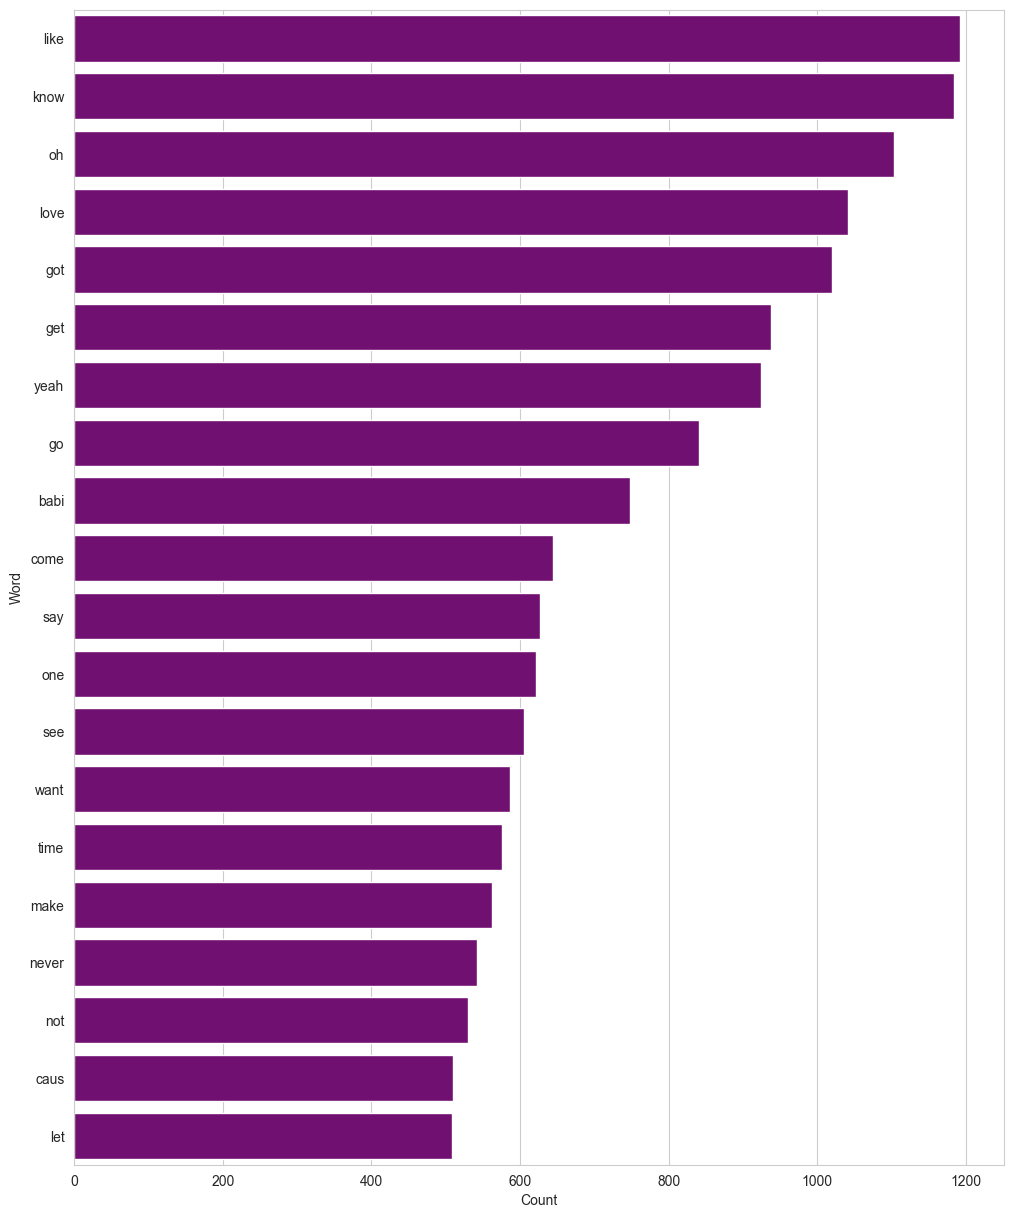

In [31]:
freq_words(song_lyric_df['CleanedLyrics'], 20)

**Top words across Hiphop**

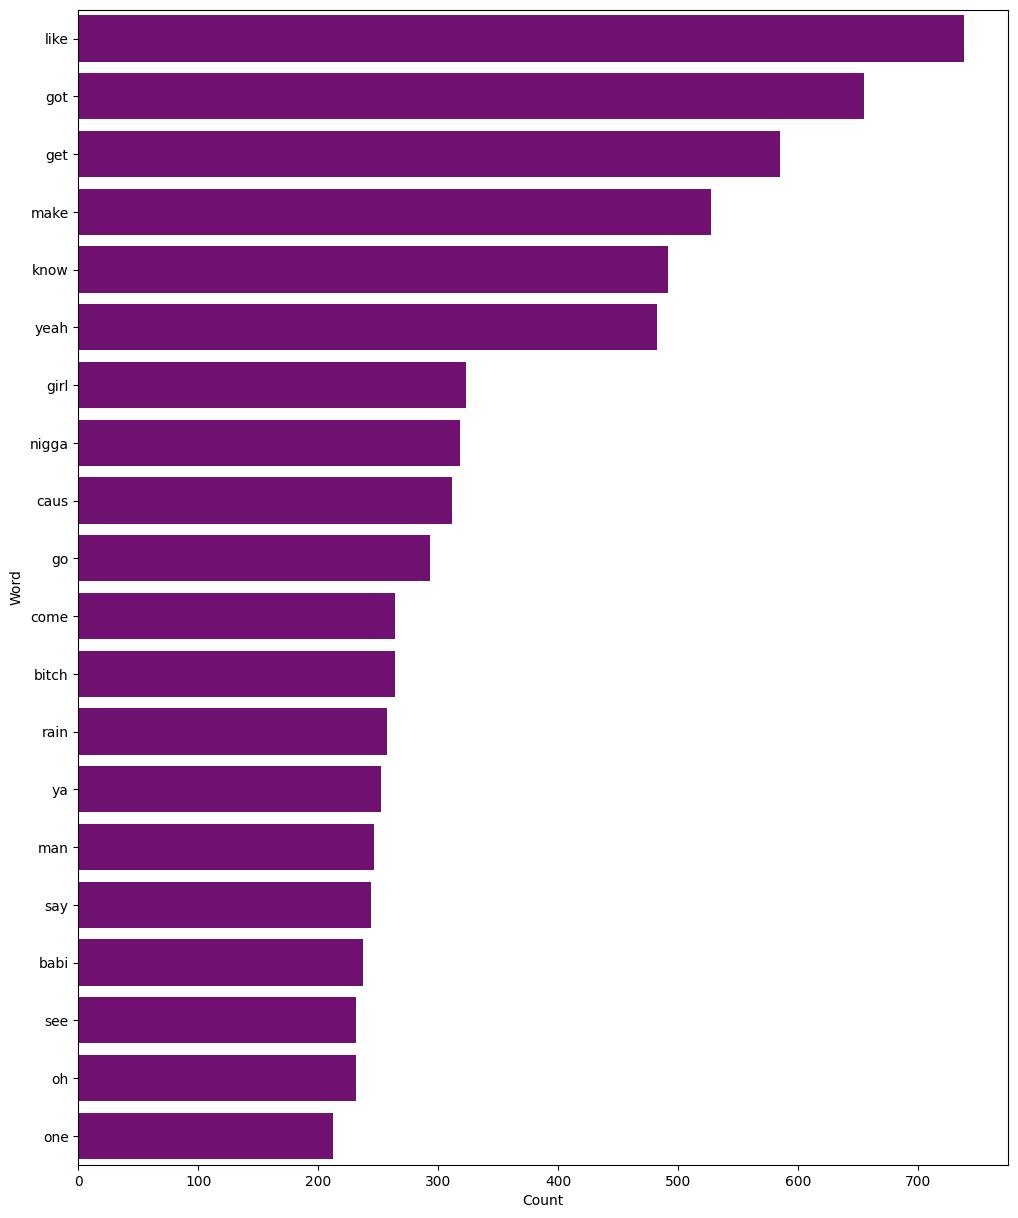

In [204]:
freq_words(hiphop_df_imported['CleanedLyrics'], 20)

**Country most spoken words**

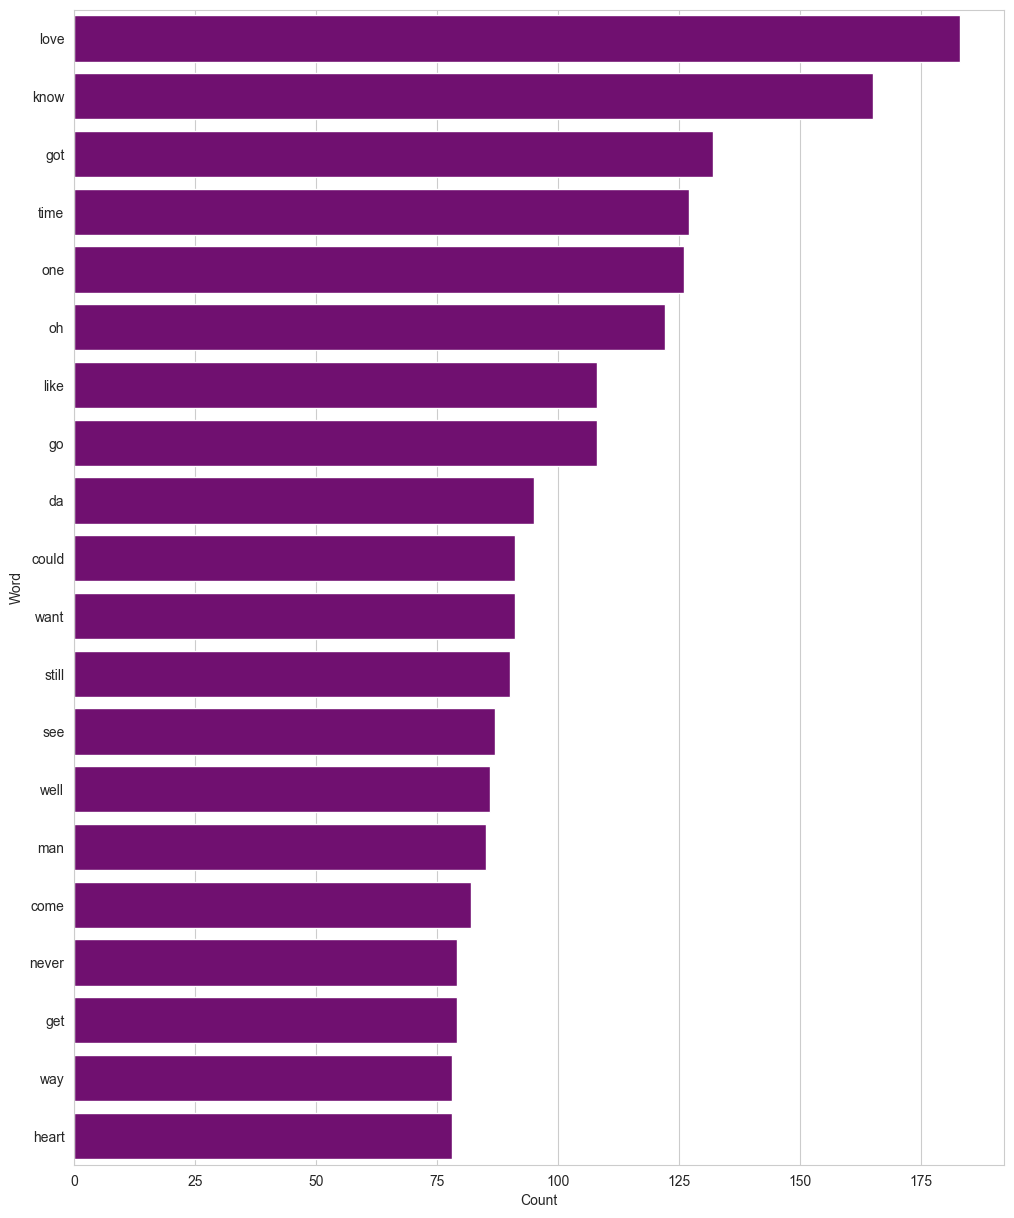

In [110]:
freq_words(country_df_imported['CleanedLyrics'], 20)

**Pop most spoken words**

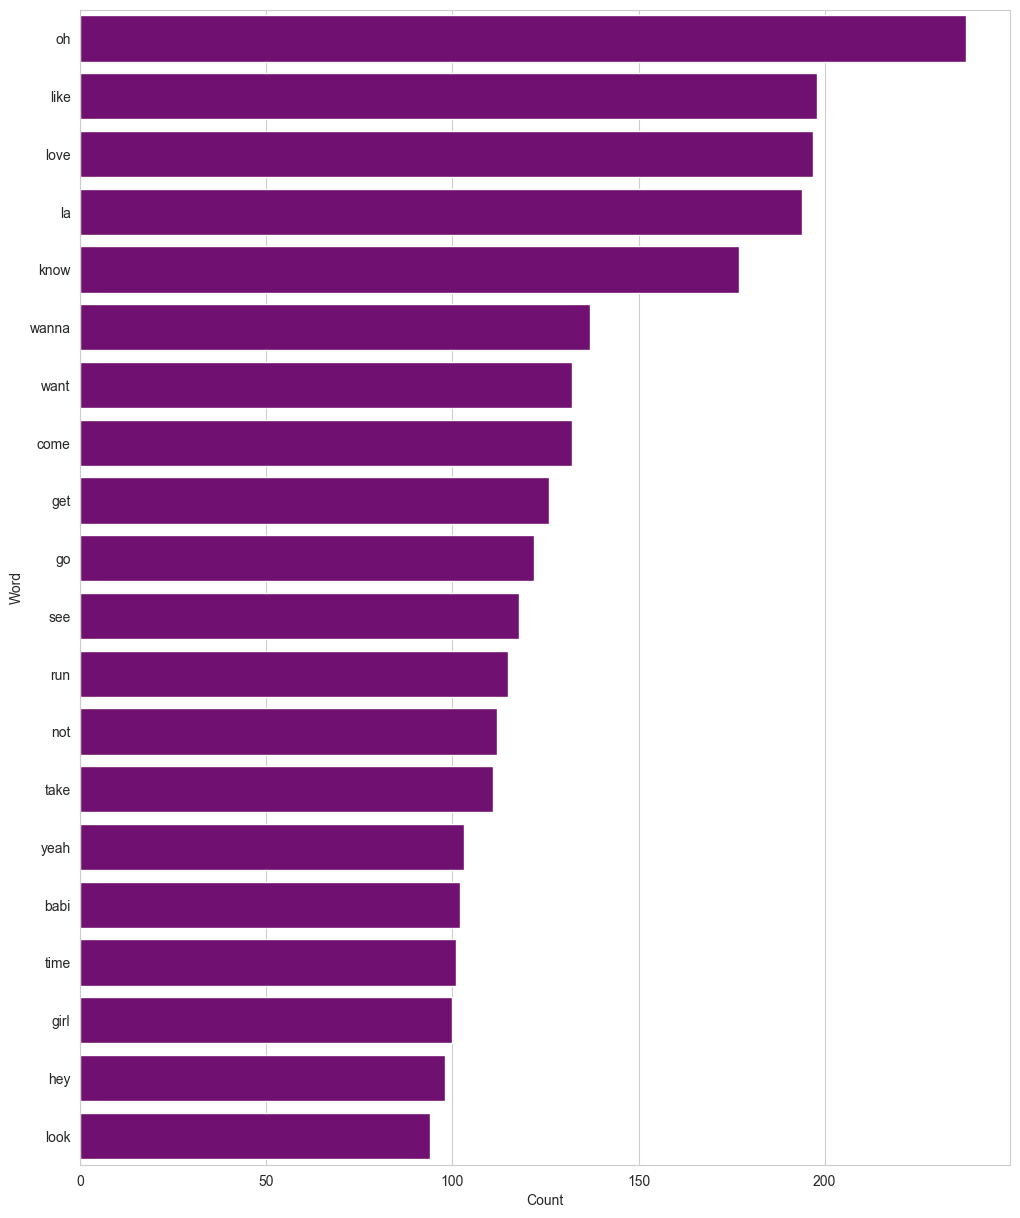

In [111]:
freq_words(pop_df_imported['CleanedLyrics'], 20)

**Rock most spoken words**

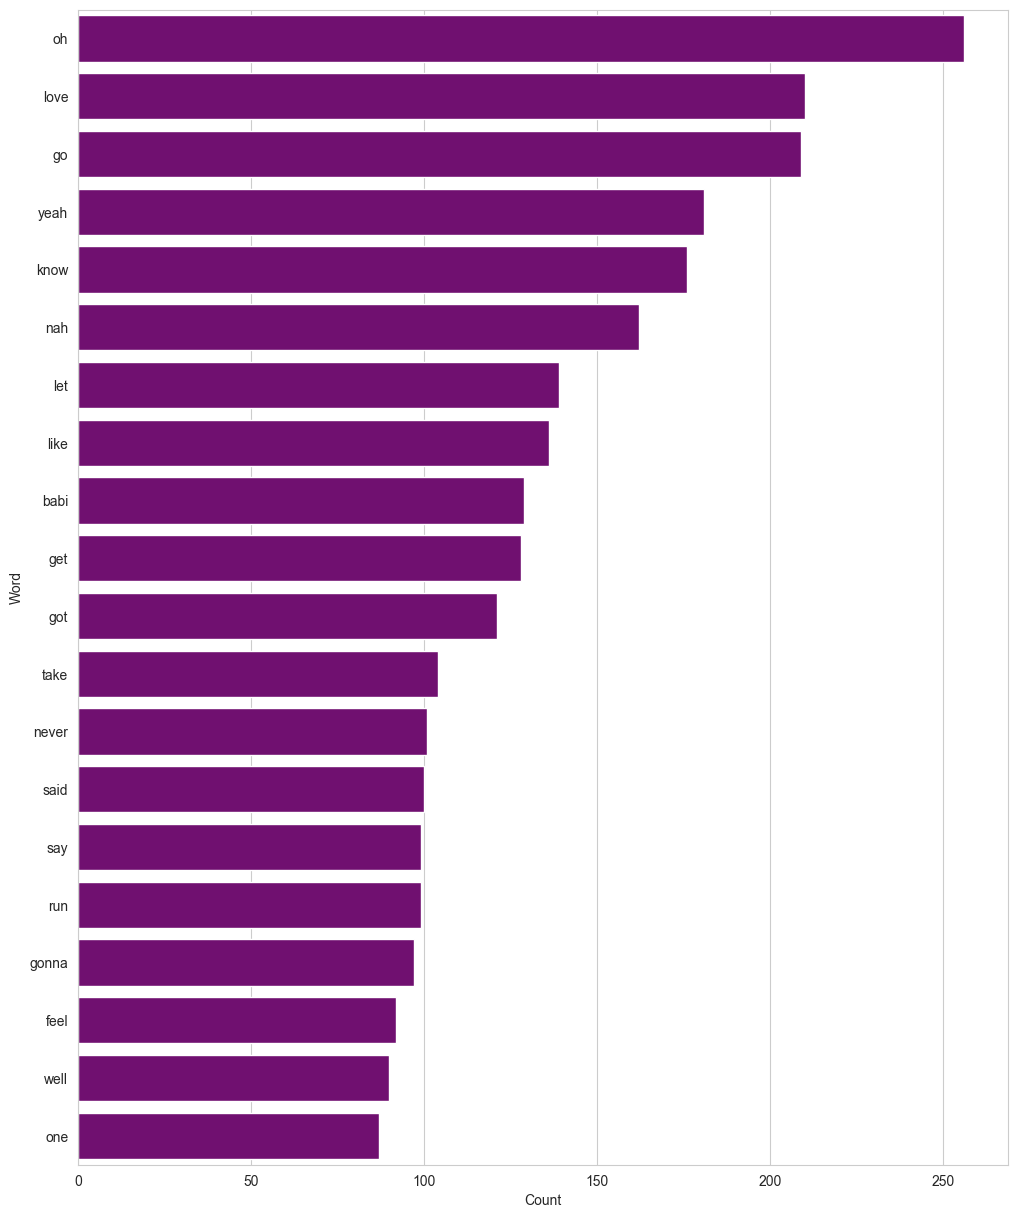

In [112]:
freq_words(rock_df_imported['CleanedLyrics'], 20)

**Singer songwriter most spoken words**

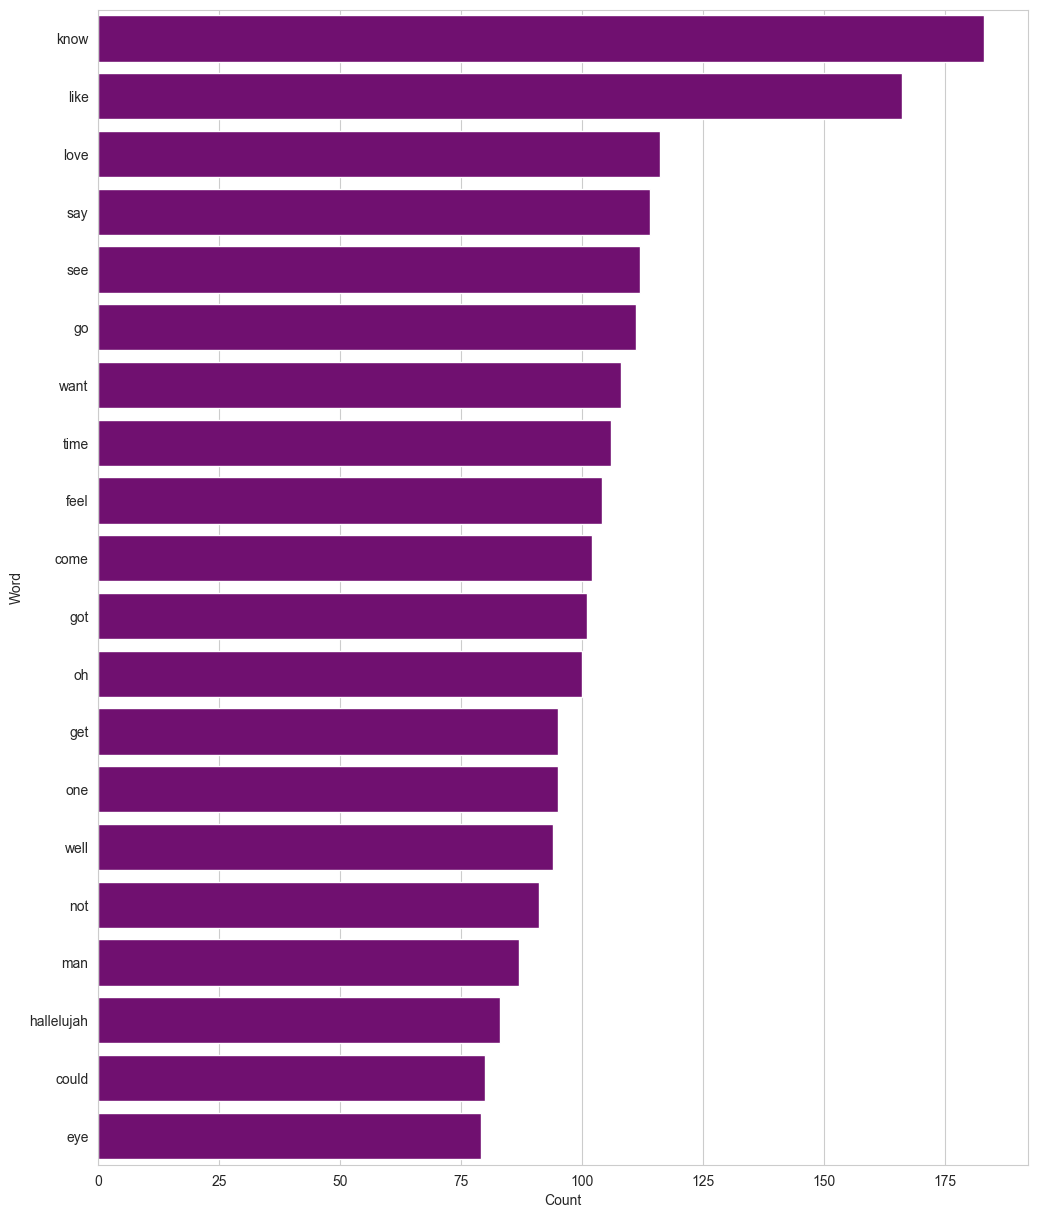

In [113]:
freq_words(singersongwriter_df_imported['CleanedLyrics'], 20)

**RnB most spoken words**

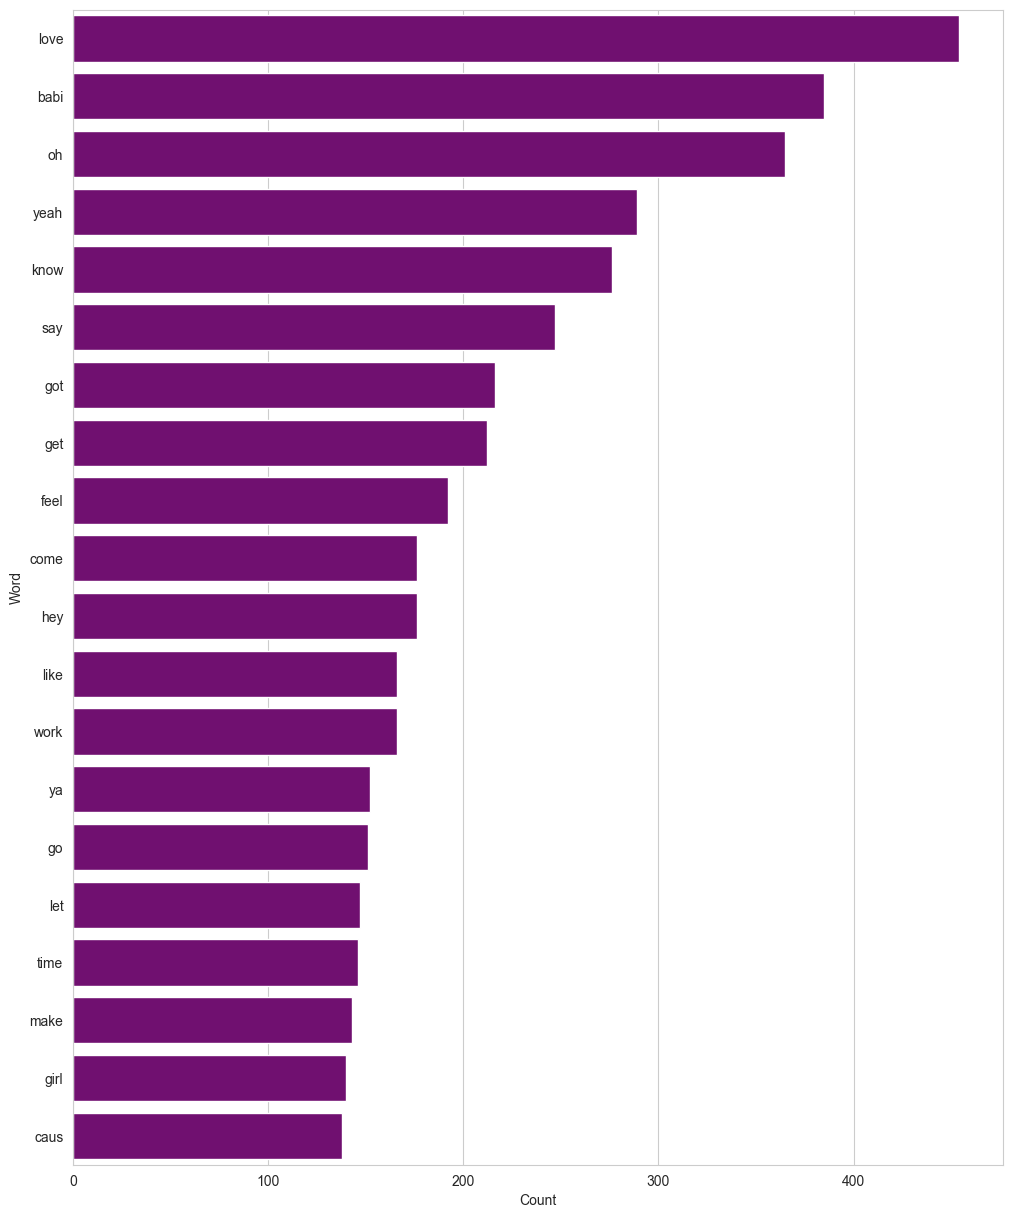

In [114]:
freq_words(rnb_df_imported['CleanedLyrics'], 20)

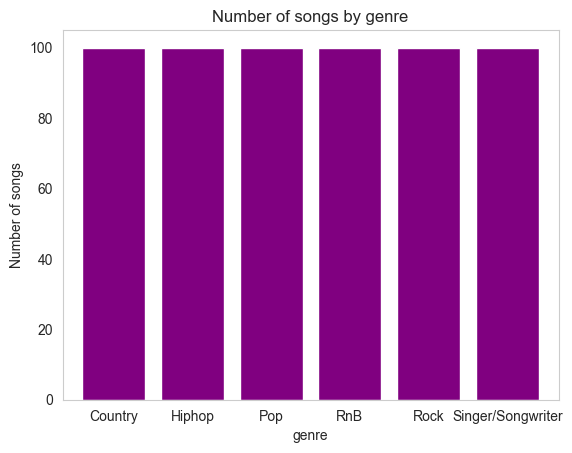

In [32]:
plot = song_lyric_df.groupby('genre').size().plot(kind='bar', width = 0.8, color ="purple", grid=False, ylabel = "Number of songs", title = "Number of songs by genre", )
plot.tick_params(rotation=0)

**Top artists by number of songs in the list**

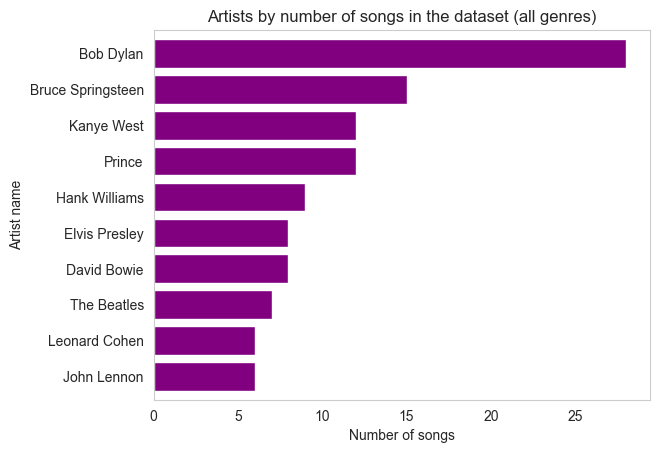

In [33]:
plot = song_lyric_df['artist'].value_counts().nlargest(n=10).sort_values(ascending=True).plot(kind='barh', width = 0.8, color ="purple", grid=False, ylabel = "Artist name", title = "Artists by number of songs in the dataset (all genres)", xlabel = "Number of songs")


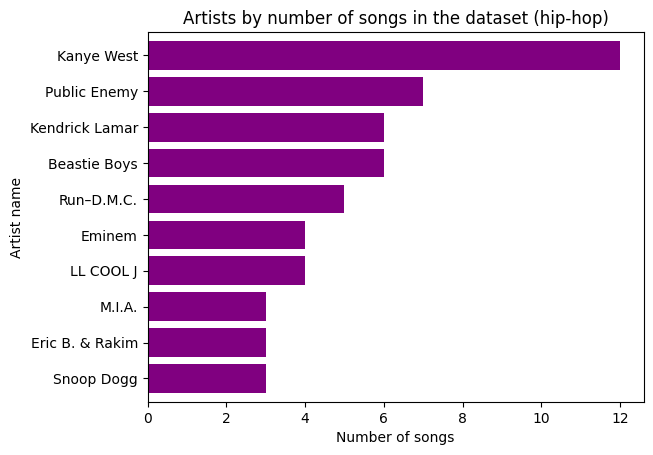

In [124]:
plot = hiphop_df_imported['artist'].value_counts().nlargest(n=10).sort_values(ascending=True).plot(kind='barh', width = 0.8, color ="purple", grid=False, ylabel = "Artist name", title = "Artists by number of songs in the dataset (hip-hop)", xlabel = "Number of songs")

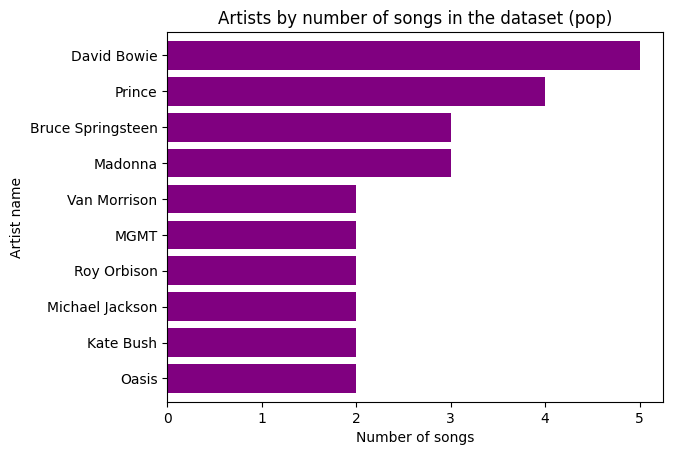

In [137]:
plot = pop_df_imported['artist'].value_counts().nlargest(n=10).sort_values(ascending=True).plot(kind='barh', width = 0.8, color ="purple", grid=False, ylabel = "Artist name", title = "Artists by number of songs in the dataset (pop)", xlabel = "Number of songs")

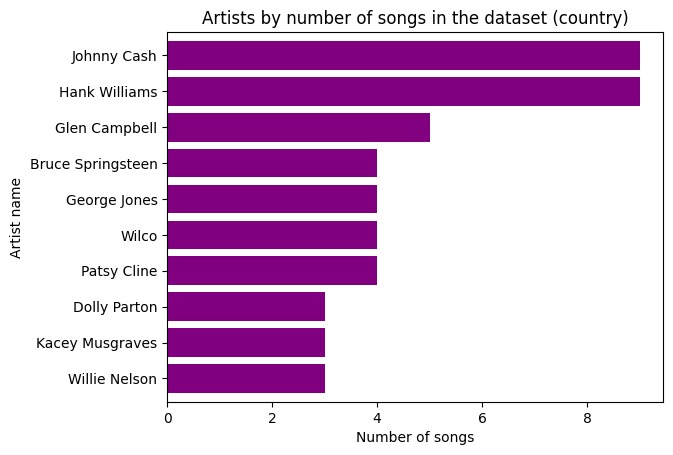

In [138]:
plot = country_df_imported['artist'].value_counts().nlargest(n=10).sort_values(ascending=True).plot(kind='barh', width = 0.8, color ="purple", grid=False, ylabel = "Artist name", title = "Artists by number of songs in the dataset (country)", xlabel = "Number of songs")

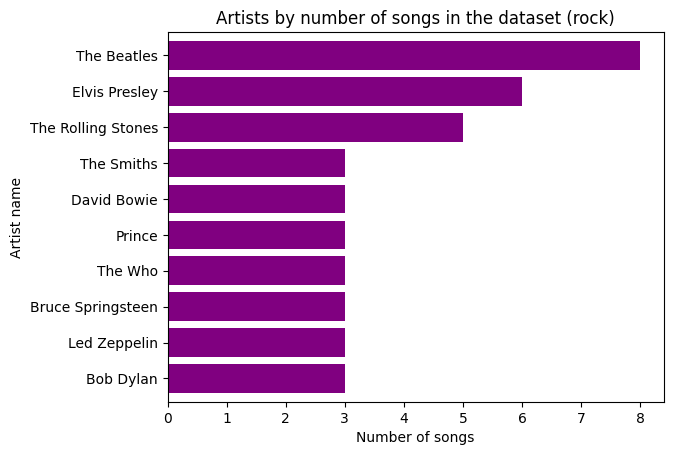

In [139]:
plot = rock_df_imported['artist'].value_counts().nlargest(n=10).sort_values(ascending=True).plot(kind='barh', width = 0.8, color ="purple", grid=False, ylabel = "Artist name", title = "Artists by number of songs in the dataset (rock)", xlabel = "Number of songs")

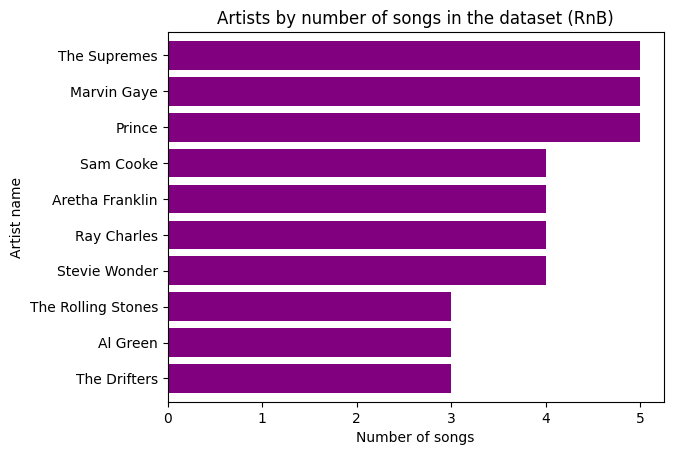

In [140]:
plot = rnb_df_imported['artist'].value_counts().nlargest(n=10).sort_values(ascending=True).plot(kind='barh', width = 0.8, color ="purple", grid=False, ylabel = "Artist name", title = "Artists by number of songs in the dataset (RnB)", xlabel = "Number of songs")

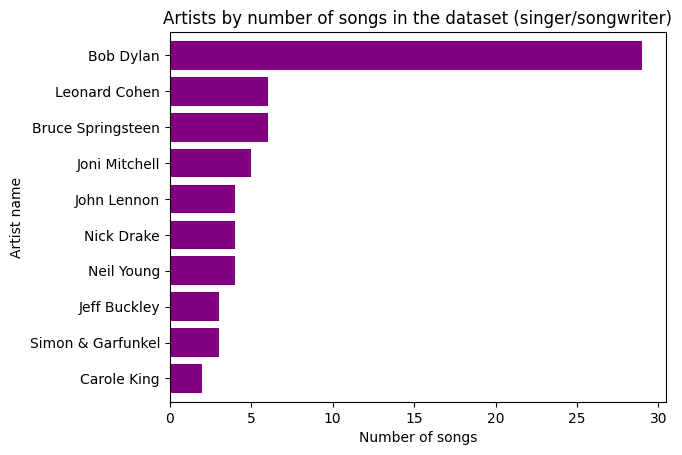

In [141]:
plot = singersongwriter_df_imported['artist'].value_counts().nlargest(n=10).sort_values(ascending=True).plot(kind='barh', width = 0.8, color ="purple", grid=False, ylabel = "Artist name", title = "Artists by number of songs in the dataset (singer/songwriter)", xlabel = "Number of songs")

We see that Bob Dylan really dominates the Singer/Songwriter genre. It will be interesting to see what results this may have.

**Find number of words in each song**

In [157]:
song_lyric_df["number_of_tokens"] = pd.NA # set placeholder value

for index in range(0,600):
    song_lyric_df.loc[index, "number_of_tokens"] = len(word_tokenize(song_lyric_df["CleanedLyrics"][index]))

**Find number of unique words in each song**

In [158]:
song_lyric_df["unique_words"] = pd.NA # set placeholder value

for index in range(0,600):
    song_lyric_df.loc[index, "unique_words"] = len(set(word_tokenize(song_lyric_df["CleanedLyrics"][index])))

In [48]:
len(set(word_tokenize(song_lyric_df["CleanedLyrics"][index])))

94

Observe below the two new columns; unique_words, number_of_tokens

In [41]:
song_lyric_df

artist                         title              genre  \
0            M.I.A.                  Paper Planes             Hiphop   
1              Beck                         Loser             Hiphop   
2      Public Enemy               Fight The Power             Hiphop   
3    Kendrick Lamar                       Alright             Hiphop   
4             JAY-Z                   99 Problems             Hiphop   
..              ...                           ...                ...   
595    Gram Parsons  Return of the Grievous Angel  Singer/Songwriter   
596       Phil Ochs      I Ain't Marching Anymore  Singer/Songwriter   
597    Neil Diamond                Sweet Caroline  Singer/Songwriter   
598       Bob Dylan        Shelter from the Storm  Singer/Songwriter   
599      Lucy Dacus                   Night Shift  Singer/Songwriter   

                                                   URL  \
0      http://azlyrics.com/lyrics/mia/paperplanes.html   
1           http://azlyrics.com/lyrics/beck/loser.html   
2    http://azlyrics.com/lyrics/publicenemy/fightth...   
3    http://azlyrics.com/lyrics/kendricklamar/alrig...   
4      http://azlyrics.com/lyrics/jayz/99problems.html   
..                                                 ...   
595  http://azlyrics.com/lyrics/gramparsons/returno...   
596  http://azlyrics.com/lyrics/philochs/iaintmarch...   
597  http://azlyrics.com/lyrics/neildiamond/sweetca...   
598  http://azlyrics.com/lyrics/bobdylan/shelterfro...   
599  http://azlyrics.com/lyrics/lucydacus/nightshif...   

                                                lyrics  \
0    \n\r\nI fly like paper, get high like planes\n...   
1    \n\r\nIn the time of chimpanzees\nI was a monk...   
2    \n\r\n"Yet our best trained, best educated, be...   
3    \n\n[Kendrick Lamar:]\nAlls my life, I has to ...   
4    \n\r\nIf you're having girl problems, I feel b...   
..                                                 ...   
595  \n\r\nWon't you scratch my itch sweet Annie Ri...   
596  \n\r\nOh, I marched to the battle of New Orlea...   
597  \n\r\nWhere it began\nI can't begin to knowin'...   
598  \n\r\n'Twas in another lifetime one of toil an...   
599  \n\r\nThe first time I tasted somebody else's ...   

                                         CleanedLyrics unique_words  \
0    fli like paper get high like plane catch borde...           80   
1    time chimpanze monkey butan vein cut junki pla...          132   
2    yet best train best educ best equip best prepa...          135   
3    kendrick lamar all life fight nigga all life h...          197   
4    girl problem feel bad son got problem bitch on...          199   
..                                                 ...          ...   
595  scratch itch sweet anni rich welcom back town ...           95   
596  oh march battl new orlean end earli british wa...           87   
597  began begin knowin know growin strong spring s...           36   
598  twa anoth lifetim one toil blood black virtu r...          151   
599  first time tast somebodi els spit cough fit mi...           94   

    number_of_tokens  
0                211  
1                191  
2                214  
3                368  
4                356  
..               ...  
595              153  
596              136  
597               79  
598              214  
599              158  

[600 rows x 8 columns]

The code below stores the number of words in each song by genre and saves them separately. These will be used for visualisations

In [159]:
rnbwords = song_lyric_df.loc[(song_lyric_df['genre'] == 'RnB')]['number_of_tokens']
hiphopwords = song_lyric_df.loc[(song_lyric_df['genre'] == 'Hiphop')]['number_of_tokens']
rockwords = song_lyric_df.loc[(song_lyric_df['genre'] == 'Rock')]['number_of_tokens']
countrywords = song_lyric_df.loc[(song_lyric_df['genre'] == 'Country')]['number_of_tokens']
popwords = song_lyric_df.loc[(song_lyric_df['genre'] == 'Pop')]['number_of_tokens']
singersongwriterwords = song_lyric_df.loc[(song_lyric_df['genre'] == 'Singer/Songwriter')]['number_of_tokens']


In [160]:
sum(rnbwords) + sum(hiphopwords) + sum(rockwords) + sum(countrywords) + sum(popwords) + sum(singersongwriterwords)

101300

A total of 101,300 words

Do the same for unique words

In [161]:
rnbwords_unique = song_lyric_df.loc[(song_lyric_df['genre'] == 'RnB')]['unique_words']
hiphopwords_unique = song_lyric_df.loc[(song_lyric_df['genre'] == 'Hiphop')]['unique_words']
rockwords_unique = song_lyric_df.loc[(song_lyric_df['genre'] == 'Rock')]['unique_words']
countrywords_unique = song_lyric_df.loc[(song_lyric_df['genre'] == 'Country')]['unique_words']
popwords_unique = song_lyric_df.loc[(song_lyric_df['genre'] == 'Pop')]['unique_words']
singersongwriterwords_unique = song_lyric_df.loc[(song_lyric_df['genre'] == 'Singer/Songwriter')]['unique_words']

In [52]:
sum(rnbwords_unique) + sum(hiphopwords_unique) + sum(rockwords_unique) + sum(countrywords_unique) + sum(popwords_unique) + sum(singersongwriterwords_unique)

50135

50,135 unique words

In [29]:
(50135 / 101300) * 100

49.49160908193485

In [30]:
song_lyric_df

artist                         title              genre  \
0            M.I.A.                  Paper Planes             Hiphop   
1              Beck                         Loser             Hiphop   
2      Public Enemy               Fight The Power             Hiphop   
3    Kendrick Lamar                       Alright             Hiphop   
4             JAY-Z                   99 Problems             Hiphop   
..              ...                           ...                ...   
595    Gram Parsons  Return of the Grievous Angel  Singer/Songwriter   
596       Phil Ochs      I Ain't Marching Anymore  Singer/Songwriter   
597    Neil Diamond                Sweet Caroline  Singer/Songwriter   
598       Bob Dylan        Shelter from the Storm  Singer/Songwriter   
599      Lucy Dacus                   Night Shift  Singer/Songwriter   

                                                   URL  \
0      http://azlyrics.com/lyrics/mia/paperplanes.html   
1           http://azlyrics.com/lyrics/beck/loser.html   
2    http://azlyrics.com/lyrics/publicenemy/fightth...   
3    http://azlyrics.com/lyrics/kendricklamar/alrig...   
4      http://azlyrics.com/lyrics/jayz/99problems.html   
..                                                 ...   
595  http://azlyrics.com/lyrics/gramparsons/returno...   
596  http://azlyrics.com/lyrics/philochs/iaintmarch...   
597  http://azlyrics.com/lyrics/neildiamond/sweetca...   
598  http://azlyrics.com/lyrics/bobdylan/shelterfro...   
599  http://azlyrics.com/lyrics/lucydacus/nightshif...   

                                                lyrics  \
0    \n\r\nI fly like paper, get high like planes\n...   
1    \n\r\nIn the time of chimpanzees\nI was a monk...   
2    \n\r\n"Yet our best trained, best educated, be...   
3    \n\n[Kendrick Lamar:]\nAlls my life, I has to ...   
4    \n\r\nIf you're having girl problems, I feel b...   
..                                                 ...   
595  \n\r\nWon't you scratch my itch sweet Annie Ri...   
596  \n\r\nOh, I marched to the battle of New Orlea...   
597  \n\r\nWhere it began\nI can't begin to knowin'...   
598  \n\r\n'Twas in another lifetime one of toil an...   
599  \n\r\nThe first time I tasted somebody else's ...   

                                         CleanedLyrics number_of_tokens  \
0    fli like paper get high like plane catch borde...              211   
1    time chimpanze monkey butan vein cut junki pla...              191   
2    yet best train best educ best equip best prepa...              214   
3    kendrick lamar all life fight nigga all life h...              368   
4    girl problem feel bad son got problem bitch on...              356   
..                                                 ...              ...   
595  scratch itch sweet anni rich welcom back town ...              153   
596  oh march battl new orlean end earli british wa...              136   
597  began begin knowin know growin strong spring s...               79   
598  twa anoth lifetim one toil blood black virtu r...              214   
599  first time tast somebodi els spit cough fit mi...              158   

    unique_words  
0             80  
1            132  
2            135  
3            197  
4            199  
..           ...  
595           95  
596           87  
597           36  
598          151  
599           94  

[600 rows x 8 columns]

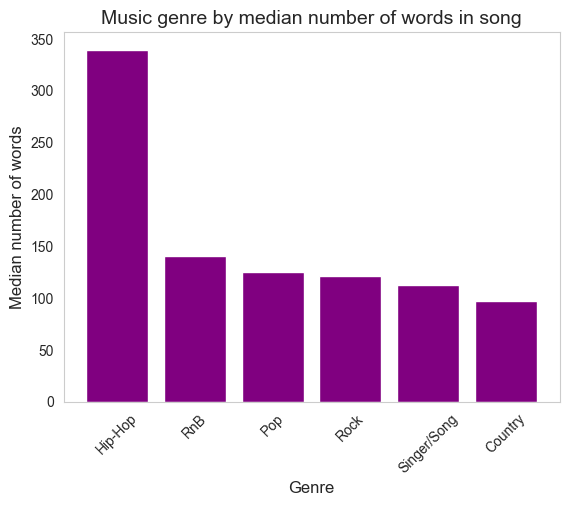

In [31]:
classes = ['RnB', 'Hip-Hop', 'Rock', 'Country', 'Pop', "Singer/Song"]
values = [median(rnbwords), median(hiphopwords), median(rockwords), median(countrywords), median(popwords), median(singersongwriterwords)]

combined_data = list(zip(values, classes))
combined_data.sort(reverse=True)  # Sort descending
values, classes = zip(*combined_data)

plt.bar(classes, values, color = 'purple')

plt.xlabel('Genre', fontsize=12)
plt.xticks(rotation = 45)
plt.ylabel('Median number of words', fontsize=12)
plt.title('Music genre by median number of words in song', fontsize=14)
plt.grid(False)

plt.show()

In [33]:
song_lyric_df

artist                         title              genre  \
0            M.I.A.                  Paper Planes             Hiphop   
1              Beck                         Loser             Hiphop   
2      Public Enemy               Fight The Power             Hiphop   
3    Kendrick Lamar                       Alright             Hiphop   
4             JAY-Z                   99 Problems             Hiphop   
..              ...                           ...                ...   
595    Gram Parsons  Return of the Grievous Angel  Singer/Songwriter   
596       Phil Ochs      I Ain't Marching Anymore  Singer/Songwriter   
597    Neil Diamond                Sweet Caroline  Singer/Songwriter   
598       Bob Dylan        Shelter from the Storm  Singer/Songwriter   
599      Lucy Dacus                   Night Shift  Singer/Songwriter   

                                                   URL  \
0      http://azlyrics.com/lyrics/mia/paperplanes.html   
1           http://azlyrics.com/lyrics/beck/loser.html   
2    http://azlyrics.com/lyrics/publicenemy/fightth...   
3    http://azlyrics.com/lyrics/kendricklamar/alrig...   
4      http://azlyrics.com/lyrics/jayz/99problems.html   
..                                                 ...   
595  http://azlyrics.com/lyrics/gramparsons/returno...   
596  http://azlyrics.com/lyrics/philochs/iaintmarch...   
597  http://azlyrics.com/lyrics/neildiamond/sweetca...   
598  http://azlyrics.com/lyrics/bobdylan/shelterfro...   
599  http://azlyrics.com/lyrics/lucydacus/nightshif...   

                                                lyrics  \
0    \n\r\nI fly like paper, get high like planes\n...   
1    \n\r\nIn the time of chimpanzees\nI was a monk...   
2    \n\r\n"Yet our best trained, best educated, be...   
3    \n\n[Kendrick Lamar:]\nAlls my life, I has to ...   
4    \n\r\nIf you're having girl problems, I feel b...   
..                                                 ...   
595  \n\r\nWon't you scratch my itch sweet Annie Ri...   
596  \n\r\nOh, I marched to the battle of New Orlea...   
597  \n\r\nWhere it began\nI can't begin to knowin'...   
598  \n\r\n'Twas in another lifetime one of toil an...   
599  \n\r\nThe first time I tasted somebody else's ...   

                                         CleanedLyrics number_of_tokens  \
0    fli like paper get high like plane catch borde...              211   
1    time chimpanze monkey butan vein cut junki pla...              191   
2    yet best train best educ best equip best prepa...              214   
3    kendrick lamar all life fight nigga all life h...              368   
4    girl problem feel bad son got problem bitch on...              356   
..                                                 ...              ...   
595  scratch itch sweet anni rich welcom back town ...              153   
596  oh march battl new orlean end earli british wa...              136   
597  began begin knowin know growin strong spring s...               79   
598  twa anoth lifetim one toil blood black virtu r...              214   
599  first time tast somebodi els spit cough fit mi...              158   

    unique_words  
0             80  
1            132  
2            135  
3            197  
4            199  
..           ...  
595           95  
596           87  
597           36  
598          151  
599           94  

[600 rows x 8 columns]

<function matplotlib.pyplot.show(close=None, block=None)>

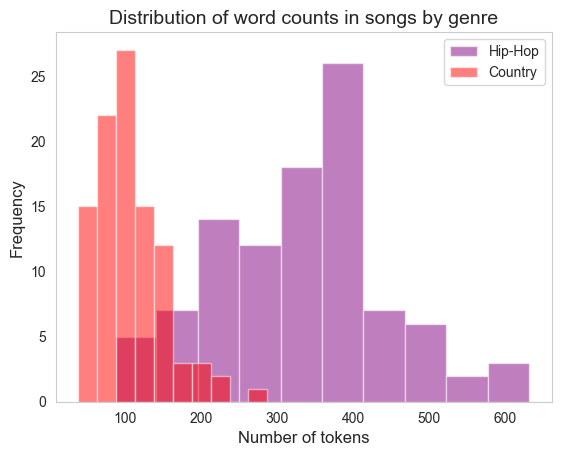

In [63]:
#plt.hist(rnbwords, alpha = 0.5)
plt.hist(hiphopwords, alpha = 0.5, color = 'purple')
#plt.hist(rockwords, alpha = 0.5)
plt.hist(countrywords, alpha = 0.5, color = 'red')

plt.grid(False)
plt.title("Distribution of word counts in songs by genre", fontsize=14)
plt.xlabel("Number of tokens", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
#plt.legend(['RnB', 'HipHop', 'Rock', 'Country'])
plt.legend(['Hip-Hop', 'Country'])

plt.show

In [64]:
median(rnbwords_unique)

54.5

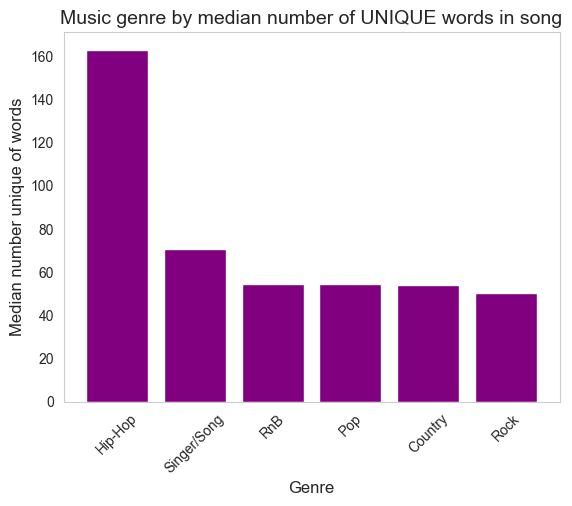

In [65]:
classes = ['RnB', 'Hip-Hop', 'Rock', 'Country', 'Pop', "Singer/Song"]
values = [median(rnbwords_unique), median(hiphopwords_unique), median(rockwords_unique), median(countrywords_unique), median(popwords_unique), median(singersongwriterwords_unique)]

combined_data = list(zip(values, classes))
combined_data.sort(reverse=True)  # Sort descending
values, classes = zip(*combined_data)

plt.bar(classes, values, color = 'purple')

plt.xlabel('Genre', fontsize=12)
plt.xticks(rotation = 45)
plt.ylabel('Median number unique of words', fontsize=12)
plt.title('Music genre by median number of UNIQUE words in song', fontsize=14)
plt.grid(False)

plt.show()

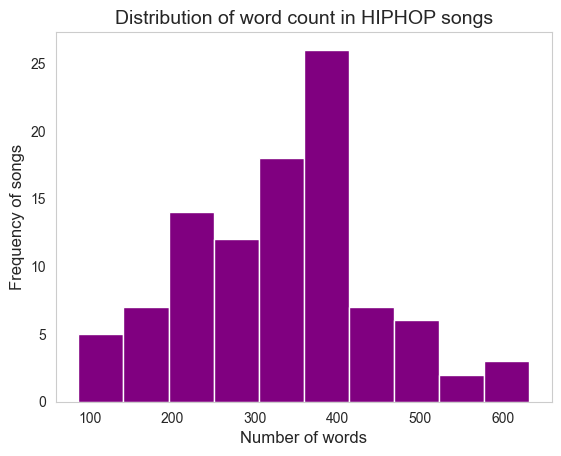

In [125]:
plt.hist(hiphopwords, color = 'purple')
plt.xlabel('Number of words', fontsize=12)
plt.ylabel('Frequency of songs', fontsize=12)
plt.title('Distribution of word count in HIPHOP songs', fontsize=14)
plt.grid(False)

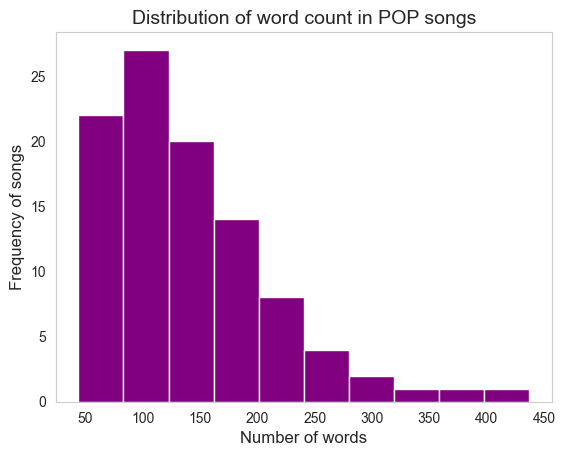

In [128]:
plt.hist(popwords, color = 'purple')
plt.xlabel('Number of words', fontsize=12)
plt.ylabel('Frequency of songs', fontsize=12)
plt.title('Distribution of word count in POP songs', fontsize=14)
plt.grid(False)

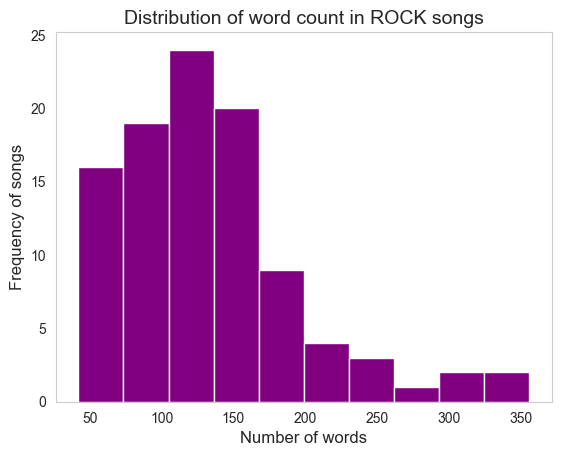

In [131]:
plt.hist(rockwords, color = 'purple')
plt.xlabel('Number of words', fontsize=12)
plt.ylabel('Frequency of songs', fontsize=12)
plt.title('Distribution of word count in ROCK songs', fontsize=14)
plt.grid(False)

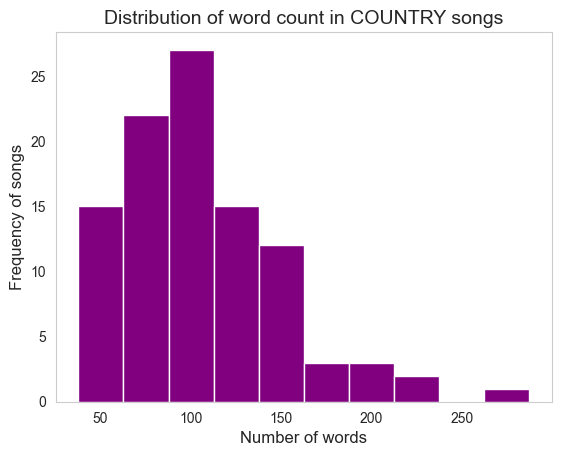

In [132]:
plt.hist(countrywords, color = 'purple')
plt.xlabel('Number of words', fontsize=12)
plt.ylabel('Frequency of songs', fontsize=12)
plt.title('Distribution of word count in COUNTRY songs', fontsize=14)
plt.grid(False)

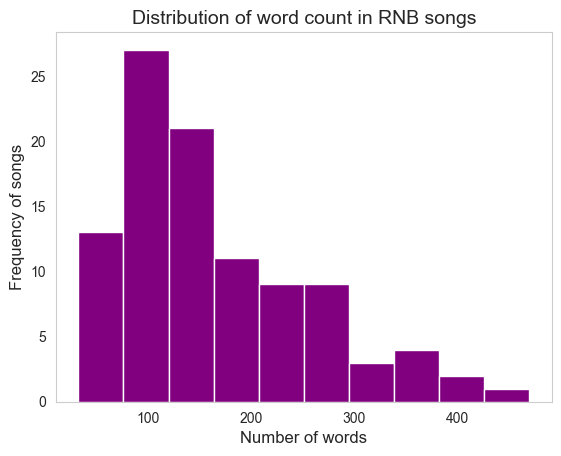

In [134]:
plt.hist(rnbwords, color = 'purple')
plt.xlabel('Number of words', fontsize=12)
plt.ylabel('Frequency of songs', fontsize=12)
plt.title('Distribution of word count in RNB songs', fontsize=14)
plt.grid(False)

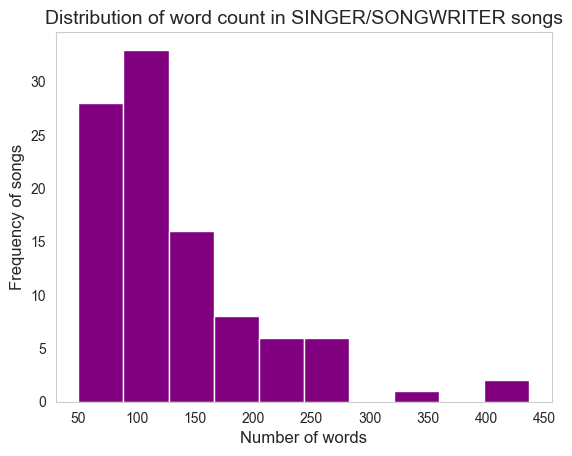

In [135]:
plt.hist(singersongwriterwords, color = 'purple')
plt.xlabel('Number of words', fontsize=12)
plt.ylabel('Frequency of songs', fontsize=12)
plt.title('Distribution of word count in SINGER/SONGWRITER songs', fontsize=14)
plt.grid(False)

In [66]:
sum(hiphopwords) / sum(hiphopwords_unique)

1.9692591271256987

In [62]:
median(hiphopwords) / median(hiphopwords_unique)

2.0828220858895707

In [84]:
mean(hiphopwords_unique) / mean(hiphopwords)


0.5078051873546907

In [83]:
median(singersongwriterwords_unique) / median(singersongwriterwords)

0.6266666666666667

In [82]:
median(rnbwords_unique) / median(rnbwords) 

0.3892857142857143

In [81]:
median(popwords_unique) / median(popwords)

0.4342629482071713

In [80]:
median(countrywords_unique) / median(countrywords) 

0.5567010309278351

In [79]:
median(rockwords_unique) / median(rockwords)

0.41735537190082644

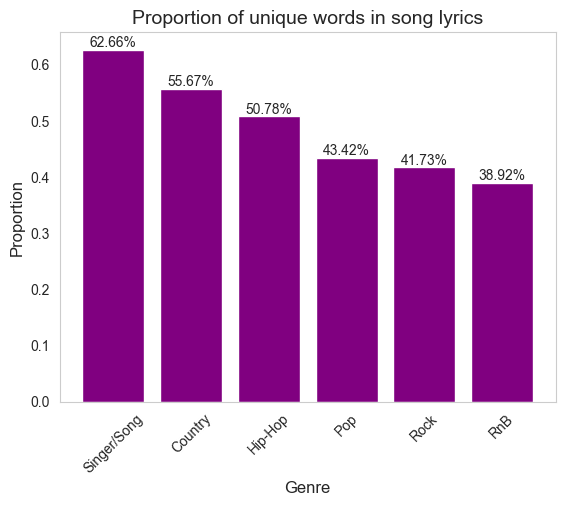

In [67]:
classes = ['RnB', 'Hip-Hop', 'Rock', 'Country', 'Pop', "Singer/Song"]
values = [median(rnbwords_unique) / median(rnbwords), mean(hiphopwords_unique) / mean(hiphopwords), median(rockwords_unique) / median(rockwords),median(countrywords_unique) / median(countrywords), median(popwords_unique) / median(popwords), median(singersongwriterwords_unique) / median(singersongwriterwords)]

combined_data = list(zip(values, classes))
combined_data.sort(reverse=True)  # Sort descending
values, classes = zip(*combined_data)

#plt.bar(classes, values, color = 'purple')

bars = plt.bar(classes, values, color = "purple")  # Store the bar objects

# Add value labels to the bars
for bar in bars:
    height = bar.get_height()
    label_text = (f'{str(height*100)[0:5]}%')  # Convert height to string
    plt.text(bar.get_x() + bar.get_width() / 2, height, label_text,
             ha='center', va='bottom') 

plt.xlabel('Genre', fontsize=12)
plt.xticks(rotation = 45)
plt.ylabel('Proportion', fontsize=12)
plt.title('Proportion of unique words in song lyrics', fontsize=14)
plt.grid(False)

plt.show()

Singer/songwriter has the highest proportion of unique words whereas RnB has the lowest. This means RnB has a lot of word repetition.

## Machine Learning

Plan: LDA and then maybe Word2Vec?

In [63]:
song_lyric_df

artist                         title              genre  \
0            M.I.A.                  Paper Planes             Hiphop   
1              Beck                         Loser             Hiphop   
2      Public Enemy               Fight The Power             Hiphop   
3    Kendrick Lamar                       Alright             Hiphop   
4             JAY-Z                   99 Problems             Hiphop   
..              ...                           ...                ...   
595    Gram Parsons  Return of the Grievous Angel  Singer/Songwriter   
596       Phil Ochs      I Ain't Marching Anymore  Singer/Songwriter   
597    Neil Diamond                Sweet Caroline  Singer/Songwriter   
598       Bob Dylan        Shelter from the Storm  Singer/Songwriter   
599      Lucy Dacus                   Night Shift  Singer/Songwriter   

                                                   URL  \
0      http://azlyrics.com/lyrics/mia/paperplanes.html   
1           http://azlyrics.com/lyrics/beck/loser.html   
2    http://azlyrics.com/lyrics/publicenemy/fightth...   
3    http://azlyrics.com/lyrics/kendricklamar/alrig...   
4      http://azlyrics.com/lyrics/jayz/99problems.html   
..                                                 ...   
595  http://azlyrics.com/lyrics/gramparsons/returno...   
596  http://azlyrics.com/lyrics/philochs/iaintmarch...   
597  http://azlyrics.com/lyrics/neildiamond/sweetca...   
598  http://azlyrics.com/lyrics/bobdylan/shelterfro...   
599  http://azlyrics.com/lyrics/lucydacus/nightshif...   

                                                lyrics  \
0    \n\r\nI fly like paper, get high like planes\n...   
1    \n\r\nIn the time of chimpanzees\nI was a monk...   
2    \n\r\n"Yet our best trained, best educated, be...   
3    \n\n[Kendrick Lamar:]\nAlls my life, I has to ...   
4    \n\r\nIf you're having girl problems, I feel b...   
..                                                 ...   
595  \n\r\nWon't you scratch my itch sweet Annie Ri...   
596  \n\r\nOh, I marched to the battle of New Orlea...   
597  \n\r\nWhere it began\nI can't begin to knowin'...   
598  \n\r\n'Twas in another lifetime one of toil an...   
599  \n\r\nThe first time I tasted somebody else's ...   

                                         CleanedLyrics  
0    fli like paper get high like plane catch borde...  
1    time chimpanze monkey butan vein cut junki pla...  
2    yet best train best educ best equip best prepa...  
3    kendrick lamar all life fight nigga all life h...  
4    girl problem feel bad son got problem bitch on...  
..                                                 ...  
595  scratch itch sweet anni rich welcom back town ...  
596  oh march battl new orlean end earli british wa...  
597  began begin knowin know growin strong spring s...  
598  twa anoth lifetim one toil blood black virtu r...  
599  first time tast somebodi els spit cough fit mi...  

[600 rows x 6 columns]

In [11]:
song_lyric_df.loc[(song_lyric_df['genre'] == 'Hiphop')]['CleanedLyrics']

0     fli like paper get high like plane catch borde...
1     time chimpanze monkey butan vein cut junki pla...
2     yet best train best educ best equip best prepa...
3     kendrick lamar all life fight nigga all life h...
4     girl problem feel bad son got problem bitch on...
                            ...                        
95    music video intro last octob grammi nomin prod...
96    flash light light light flash light light ligh...
97    daft punk work make make us harder better fast...
98    alon room sometim stare wall back mind hear co...
99    kid cudi day night toss turn keep stress mind ...
Name: CleanedLyrics, Length: 100, dtype: object

In [42]:
def create_wordcloud(lyrics):
    '''Creates a wordcloud from cleaned lyrics'''
    long_string = ','.join(list(lyrics))
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()





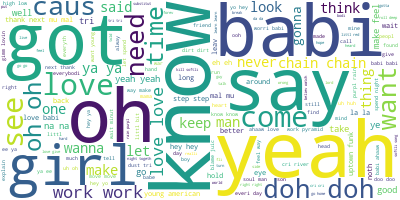

In [46]:
cleaned_hiphop_lyrics = song_lyric_df.loc[(song_lyric_df['genre'] == 'Hiphop')]['CleanedLyrics']
cleaned_rnb_lyrics = song_lyric_df.loc[(song_lyric_df['genre'] == 'RnB')]['CleanedLyrics']


create_wordcloud(cleaned_rnb_lyrics)

In [18]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))  # deacc = True removes punctuations

data_words = list(sent_to_words(song_lyric_df["CleanedLyrics"]))
#data_words


In [19]:
data_words

[['fli',
  'like',
  'paper',
  'get',
  'high',
  'like',
  'plane',
  'catch',
  'border',
  'got',
  'visa',
  'name',
  'come',
  'around',
  'make',
  'em',
  'day',
  'get',
  'one',
  'done',
  'second',
  'wait',
  'fli',
  'like',
  'paper',
  'get',
  'high',
  'like',
  'plane',
  'catch',
  'border',
  'got',
  'visa',
  'name',
  'come',
  'around',
  'make',
  'em',
  'day',
  'get',
  'one',
  'done',
  'second',
  'wait',
  'sometim',
  'think',
  'sit',
  'train',
  'everi',
  'stop',
  'get',
  'clock',
  'game',
  'everyon',
  'winner',
  'make',
  'fame',
  'bona',
  'fide',
  'hustler',
  'make',
  'name',
  'sometim',
  'think',
  'sit',
  'train',
  'everi',
  'stop',
  'get',
  'clock',
  'game',
  'everyon',
  'winner',
  'make',
  'fame',
  'bona',
  'fide',
  'hustler',
  'make',
  'name',
  'wanna',
  'take',
  'money',
  'wanna',
  'take',
  'money',
  'wanna',
  'take',
  'money',
  'wanna',
  'take',
  'money',
  'pirat',
  'skull',
  'bone',
  'stick',
 

In [57]:
bigram = gensim.models.Phrases(data_words, min_count=1, delimiter=' ') # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], min_count=1, delimiter=' ')  

In [59]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [63]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_bigrams = make_bigrams(data_words)
data_words_trigrams = make_trigrams(data_words)

In [64]:
data_words_trigrams

[['fli',
  'like',
  'paper',
  'get high',
  'like',
  'plane catch border',
  'got visa',
  'name',
  'come',
  'around',
  'make',
  'em',
  'day',
  'get',
  'one',
  'done second',
  'wait',
  'fli',
  'like',
  'paper',
  'get high',
  'like',
  'plane catch border',
  'got visa',
  'name',
  'come',
  'around',
  'make',
  'em',
  'day',
  'get',
  'one',
  'done second',
  'wait',
  'sometim',
  'think',
  'sit train everi',
  'stop',
  'get',
  'clock game everyon winner',
  'make fame',
  'bona fide',
  'hustler make name',
  'sometim',
  'think',
  'sit train everi',
  'stop',
  'get',
  'clock game everyon winner',
  'make fame',
  'bona fide',
  'hustler make name',
  'wanna',
  'take money',
  'wanna',
  'take money',
  'wanna',
  'take money',
  'wanna',
  'take money',
  'pirat skull',
  'bone stick stone weed',
  'bong',
  'run',
  'hit em lethal',
  'poison system',
  'pirat skull',
  'bone stick stone weed',
  'bomb',
  'run',
  'hit em lethal',
  'poison system',
  

In [65]:
# View bigram and trigram words
my_bigrams = []
my_trigrams = []
for sent in data_words:
    bigrams_ = [b for b in bigram_mod[sent] if b.count(' ') == 1]
    trigrams_ = [t for t in trigram_mod[bigram[sent]] if t.count(' ') == 2]
    if (len(bigrams_)>0):
      my_bigrams.append(bigrams_)
      print(bigrams_)
    if(len(trigrams_)>0):
      my_trigrams.append(trigrams_)
      print(trigrams_)

['plane catch', 'got visa', 'done second', 'plane catch', 'got visa', 'done second', 'sit train', 'clock game', 'everyon winner', 'make fame', 'bona fide', 'hustler make', 'sit train', 'clock game', 'everyon winner', 'make fame', 'bona fide', 'hustler make', 'pirat skull', 'bone stick', 'stone weed', 'em lethal', 'poison system', 'pirat skull', 'bone stick', 'stone weed', 'em lethal', 'poison system', 'corner swagger', 'hit burner', 'prepaid wireless', 'pack deliv', 'like up', 'truck alreadi', 'hell pump', 'corner swagger', 'hit burner', 'prepaid wireless', 'pack deliv', 'like up', 'truck alreadi', 'hell pump', 'busi readi']
['plane catch border', 'plane catch border', 'sit train everi', 'hustler make name', 'sit train everi', 'hustler make name', 'hit em lethal', 'hit em lethal', 'us hit burner', 'truck alreadi go', 'hell pump ga', 'us hit burner', 'truck alreadi go', 'hell pump ga']
['time chimpanze', 'monkey butan', 'vein cut', 'junki plastic', 'eyebal spray', 'paint veget', 'dog fo

In [73]:
my_bigrams
my_trigrams

[['plane catch border',
  'plane catch border',
  'sit train everi',
  'hustler make name',
  'sit train everi',
  'hustler make name',
  'hit em lethal',
  'hit em lethal',
  'us hit burner',
  'truck alreadi go',
  'hell pump ga',
  'us hit burner',
  'truck alreadi go',
  'hell pump ga'],
 ['control babi reno',
  'seat someon keep',
  'trailer park yo',
  'relat trade cash',
  'beat bodi hate',
  'time piec wax',
  'kill drive bodi',
  'feel soy un',
  'babi soy un'],
 ['bum rush show'],
 ['gon alright hear',
  'feel gon alright',
  'nigga gon alright',
  'huh gon alright',
  'alright hear feel',
  'hurt nigga pride',
  'low lookin world',
  'sure nigga preacher',
  'gun might blow',
  'gon alright hear',
  'feel gon alright',
  'nigga gon alright',
  'huh gon alright',
  'alright hear feel',
  'hurt nigga pride',
  'low lookin world',
  'sure nigga preacher',
  'gun might blow',
  'gon alright hear',
  'feel gon alright',
  'nigga gon alright',
  'huh gon alright',
  'alright hear 

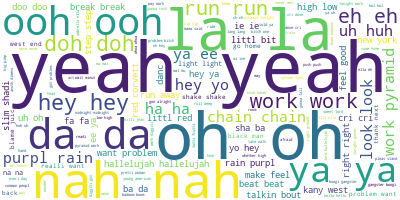

In [76]:
create_wordcloud(chain.from_iterable(my_bigrams))

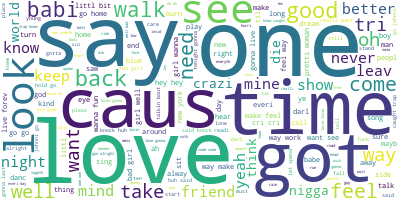

In [77]:
create_wordcloud(chain.from_iterable(my_trigrams))


**LDA setup for bigrams**

In [88]:
#LDA topic model requires two things: the dictionary(id2word) and the corpus
# Create Dictionary
id2word = corpora.Dictionary(my_bigrams) #data_words_bigrams

#filtering words less frequent and high frequent; taking only the top 100,000 keywords
#id2word.filter_extremes(keep_n=100000)

# Create Corpus
texts = my_bigrams #data_words_bigrams

# Term Document Frequency (Bag of Words Approach)
corpus = [id2word.doc2bow(text) for text in texts]


**LDA setup for words**

In [20]:
#LDA topic model requires two things: the dictionary(id2word) and the corpus
# Create Dictionary
id2word = corpora.Dictionary(data_words) #data_words_bigrams

#filtering words less frequent and high frequent; taking only the top 100,000 keywords
#id2word.filter_extremes(keep_n=100000)

# Create Corpus
texts = data_words #data_words_bigrams

# Term Document Frequency (Bag of Words Approach)
corpus = [id2word.doc2bow(text) for text in texts]

In [21]:
# View
print(corpus[1:2])

[[(24, 1), (26, 2), (28, 3), (40, 2), (72, 1), (76, 10), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 2), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 2), (107, 1), (108, 1), (109, 1), (110, 1), (111, 1), (112, 1), (113, 1), (114, 1), (115, 1), (116, 1), (117, 1), (118, 1), (119, 1), (120, 1), (121, 1), (122, 1), (123, 2), (124, 1), (125, 1), (126, 1), (127, 1), (128, 1), (129, 1), (130, 1), (131, 1), (132, 1), (133, 1), (134, 1), (135, 9), (136, 1), (137, 9), (138, 1), (139, 1), (140, 1), (141, 1), (142, 1), (143, 1), (144, 1), (145, 1), (146, 1), (147, 1), (148, 1), (149, 2), (150, 8), (151, 1), (152, 1), (153, 1), (154, 1), (155, 1), (156, 1), (157, 1), (158, 1), (159, 1), (160, 1), (161, 1), (162, 2), (163, 1), (164, 1), (165, 1), (166, 1), (167, 1), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), (173, 

In [22]:
# readable format of corpus (term-frequency) in a sentence
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[1:2]]

[[('ga', 1),
  ('get', 2),
  ('got', 3),
  ('one', 2),
  ('winner', 1),
  ('babi', 10),
  ('bag', 1),
  ('ban', 1),
  ('barrel', 1),
  ('beat', 1),
  ('beefcak', 1),
  ('believ', 2),
  ('bodi', 2),
  ('bozo', 1),
  ('breath', 1),
  ('bring', 1),
  ('buckshot', 1),
  ('burn', 1),
  ('butan', 1),
  ('car', 1),
  ('cash', 1),
  ('caus', 1),
  ('chamber', 1),
  ('chang', 1),
  ('cheez', 1),
  ('chimpanze', 1),
  ('choke', 1),
  ('cocain', 1),
  ('complain', 1),
  ('control', 1),
  ('couch', 1),
  ('coupl', 1),
  ('crap', 1),
  ('crazi', 1),
  ('cruis', 1),
  ('cut', 2),
  ('dark', 1),
  ('daytim', 1),
  ('deutsch', 1),
  ('dog', 1),
  ('doubl', 1),
  ('drive', 1),
  ('driver', 1),
  ('everyth', 1),
  ('evil', 1),
  ('eyebal', 1),
  ('face', 1),
  ('fall', 1),
  ('feel', 1),
  ('flag', 1),
  ('flame', 1),
  ('folksing', 1),
  ('food', 2),
  ('forc', 1),
  ('gonna', 1),
  ('guitar', 1),
  ('hang', 1),
  ('hate', 1),
  ('headlight', 1),
  ('hung', 1),
  ('insan', 1),
  ('job', 1),
  ('junki',

In [23]:
%%time
# Building the topic model - LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=1001,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

CPU times: total: 5.06 s
Wall time: 10.5 s


In [24]:
%%time
# Print the Keywords in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.039*"dna" + 0.007*"ganja" + 0.006*"loyalti" + 0.006*"royalti" + '
  '0.000*"dodgin" + 0.000*"heritag" + 0.000*"offend" + 0.000*"reapin" + '
  '0.000*"rot" + 0.000*"oldest"'),
 (1,
  '0.118*"babi" + 0.060*"come" + 0.057*"ooh" + 0.051*"let" + 0.037*"get" + '
  '0.033*"ah" + 0.031*"beat" + 0.025*"good" + 0.024*"make" + 0.022*"way"'),
 (2,
  '0.091*"chain" + 0.063*"fire" + 0.026*"higher" + 0.026*"explain" + '
  '0.022*"rule" + 0.016*"dream" + 0.016*"ring" + 0.015*"dollar" + '
  '0.014*"chase" + 0.014*"fuck"'),
 (3,
  '0.049*"like" + 0.026*"got" + 0.022*"everi" + 0.022*"yo" + 0.019*"hey" + '
  '0.017*"step" + 0.017*"get" + 0.013*"shit" + 0.013*"way" + 0.012*"watch"'),
 (4,
  '0.066*"song" + 0.045*"doo" + 0.039*"peopl" + 0.028*"kill" + 0.028*"said" + '
  '0.028*"common" + 0.026*"life" + 0.024*"live" + 0.024*"sing" + 0.023*"side"'),
 (5,
  '0.051*"work" + 0.044*"ya" + 0.026*"babi" + 0.024*"get" + 0.023*"gotta" + '
  '0.021*"like" + 0.019*"high" + 0.019*"low" + 0.017*"tip" + 0.014*"e

In [26]:
#Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.041504252690705

Coherence Score:  0.33083359140156393


In [27]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.264849  0.079302       1        1  32.911162
10     0.203255  0.052223       2        1  11.652386
13     0.186715  0.149965       3        1   8.895117
3      0.133677 -0.145786       4        1   6.774242
11     0.142050 -0.114512       5        1   6.467590
5      0.126127 -0.146998       6        1   5.717943
7      0.125664  0.181067       7        1   5.301206
8      0.002305  0.129478       8        1   3.976345
1      0.101063 -0.129543       9        1   3.558097
9     -0.012538 -0.189280      10        1   2.763939
6      0.027162  0.022602      11        1   2.679584
18    -0.121834 -0.058784      12        1   1.857716
16    -0.097683  0.089503      13        1   1.301349
12    -0.104914 -0.073557      14        1   1.297556
4     -0.072950  0.020554      15        1   1.283349
15    -0.118010  0.039697      16        1   1.246751
2     -0.180446  0.016108      17        1   1.240730
19    -0.189080  0.046008      18        1   0.779536
14    -0.210359  0.012210      19        1   0.242905
0     -0.205050  0.019742      20        1   0.052497, topic_info=          Term         Freq        Total Category  logprob  loglift
830         oh  1169.000000  1169.000000  Default    30.00  30.0000
138       love  1179.000000  1179.000000  Default    29.00  29.0000
75        yeah   877.000000   877.000000  Default    28.00  28.0000
76        babi   808.000000   808.000000  Default    27.00  27.0000
243        hey   413.000000   413.000000  Default    26.00  26.0000
...        ...          ...          ...      ...      ...      ...
2112    ceilin     0.006785     0.993601  Topic20    -8.95   2.5656
2115  contempl     0.006785     0.993601  Topic20    -8.95   2.5656
2117   convict     0.006785     0.993601  Topic20    -8.95   2.5656
2124     estat     0.006785     0.993601  Topic20    -8.95   2.5656
2147   immacul     0.006785     0.993601  Topic20    -8.95   2.5656

[1097 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3267     14  0.812871     aah
588       5  0.907746  addict
317       1  0.071396  afraid
317       3  0.190388  afraid
317       7  0.523568  afraid
...     ...       ...     ...
881      11  0.719376    york
585       1  0.108393   young
585       2  0.617839   young
585       5  0.265563   young
2810     15  0.488380   zombi

[1859 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 11, 14, 4, 12, 6, 8, 9, 2, 10, 7, 19, 17, 13, 5, 16, 3, 20, 15, 1])

In [64]:
limit = 24
n_col = 4
counter = 0
num_topics = 6 # set to 6 because there are 6 genres
topic_words = {}
plt.figure(figsize=(20, 16))
for ind in range(num_topics):

    title_str = "Topic{}".format(ind+1)
    topic_words[title_str] = {}
    t1 = lda_model.show_topic(ind,topn=200)
    i = 0
    word_freq = dict()
    for t,v in t1:
        if(v>0.0):
            word_freq[t] = v
            topic_words[title_str][i]=t
            i = i + 1

    wordcloud = WordCloud(background_color="white").fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title_str)
    # plt.close()

    counter += 1

NameError: name 'lda_model' is not defined

<Figure size 2000x1600 with 0 Axes>

## Mallet

In [104]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [65]:
#LDA topic model requires two things: the dictionary(id2word) and the corpus
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

#filtering words less frequent and high frequent; taking only the top 100,000 keywords
id2word.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency (Bag of Words Approach)
corpus = [id2word.doc2bow(text) for text in texts]

NameError: name 'data_words_bigrams' is not defined

## Word2Vec

In [66]:
cleaned_corpus = list(song_lyric_df['CleanedLyrics'])

In [67]:
np.random.seed(0) # make random number generation consistent

In [53]:
song_lyric_df

artist                         title              genre  \
0            M.I.A.                  Paper Planes             Hiphop   
1              Beck                         Loser             Hiphop   
2      Public Enemy               Fight The Power             Hiphop   
3    Kendrick Lamar                       Alright             Hiphop   
4             JAY-Z                   99 Problems             Hiphop   
..              ...                           ...                ...   
595    Gram Parsons  Return of the Grievous Angel  Singer/Songwriter   
596       Phil Ochs      I Ain't Marching Anymore  Singer/Songwriter   
597    Neil Diamond                Sweet Caroline  Singer/Songwriter   
598       Bob Dylan        Shelter from the Storm  Singer/Songwriter   
599      Lucy Dacus                   Night Shift  Singer/Songwriter   

                                                   URL  \
0      http://azlyrics.com/lyrics/mia/paperplanes.html   
1           http://azlyrics.com/lyrics/beck/loser.html   
2    http://azlyrics.com/lyrics/publicenemy/fightth...   
3    http://azlyrics.com/lyrics/kendricklamar/alrig...   
4      http://azlyrics.com/lyrics/jayz/99problems.html   
..                                                 ...   
595  http://azlyrics.com/lyrics/gramparsons/returno...   
596  http://azlyrics.com/lyrics/philochs/iaintmarch...   
597  http://azlyrics.com/lyrics/neildiamond/sweetca...   
598  http://azlyrics.com/lyrics/bobdylan/shelterfro...   
599  http://azlyrics.com/lyrics/lucydacus/nightshif...   

                                                lyrics  \
0    \n\r\nI fly like paper, get high like planes\n...   
1    \n\r\nIn the time of chimpanzees\nI was a monk...   
2    \n\r\n"Yet our best trained, best educated, be...   
3    \n\n[Kendrick Lamar:]\nAlls my life, I has to ...   
4    \n\r\nIf you're having girl problems, I feel b...   
..                                                 ...   
595  \n\r\nWon't you scratch my itch sweet Annie Ri...   
596  \n\r\nOh, I marched to the battle of New Orlea...   
597  \n\r\nWhere it began\nI can't begin to knowin'...   
598  \n\r\n'Twas in another lifetime one of toil an...   
599  \n\r\nThe first time I tasted somebody else's ...   

                                         CleanedLyrics unique_words  \
0    fli like paper get high like plane catch borde...           80   
1    time chimpanze monkey butan vein cut junki pla...          132   
2    yet best train best educ best equip best prepa...          135   
3    kendrick lamar all life fight nigga all life h...          197   
4    girl problem feel bad son got problem bitch on...          199   
..                                                 ...          ...   
595  scratch itch sweet anni rich welcom back town ...           95   
596  oh march battl new orlean end earli british wa...           87   
597  began begin knowin know growin strong spring s...           36   
598  twa anoth lifetim one toil blood black virtu r...          151   
599  first time tast somebodi els spit cough fit mi...           94   

    number_of_tokens  
0                211  
1                191  
2                214  
3                368  
4                356  
..               ...  
595              153  
596              136  
597               79  
598              214  
599              158  

[600 rows x 8 columns]

In [68]:
# Clean data using the built in cleaner in gensim
song_lyric_df['text_clean'] = song_lyric_df['lyrics'].apply(lambda x: gensim.utils.simple_preprocess(x))
song_lyric_df.head()

artist            title   genre  \
0          M.I.A.     Paper Planes  Hiphop   
1            Beck            Loser  Hiphop   
2    Public Enemy  Fight The Power  Hiphop   
3  Kendrick Lamar          Alright  Hiphop   
4           JAY-Z      99 Problems  Hiphop   

                                                 URL  \
0    http://azlyrics.com/lyrics/mia/paperplanes.html   
1         http://azlyrics.com/lyrics/beck/loser.html   
2  http://azlyrics.com/lyrics/publicenemy/fightth...   
3  http://azlyrics.com/lyrics/kendricklamar/alrig...   
4    http://azlyrics.com/lyrics/jayz/99problems.html   

                                              lyrics  \
0  \n\r\nI fly like paper, get high like planes\n...   
1  \n\r\nIn the time of chimpanzees\nI was a monk...   
2  \n\r\n"Yet our best trained, best educated, be...   
3  \n\n[Kendrick Lamar:]\nAlls my life, I has to ...   
4  \n\r\nIf you're having girl problems, I feel b...   

                                       CleanedLyrics  \
0  fli like paper get high like plane catch borde...   
1  time chimpanze monkey butan vein cut junki pla...   
2  yet best train best educ best equip best prepa...   
3  kendrick lamar all life fight nigga all life h...   
4  girl problem feel bad son got problem bitch on...   

                                          text_clean  
0  [fly, like, paper, get, high, like, planes, if...  
1  [in, the, time, of, chimpanzees, was, monkey, ...  
2  [yet, our, best, trained, best, educated, best...  
3  [kendrick, lamar, alls, my, life, has, to, fig...  
4  [if, you, re, having, girl, problems, feel, ba...

In [69]:
# Encoding the label column
#song_lyric_df['genre']=song_lyric_df['genre'].map({'Country':0,'Hiphop':1, 'Pop':2, 'RnB':3, 'Rock':4, 'Singer/Songwriter':5})
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(song_lyric_df['text_clean'], song_lyric_df['genre'] , test_size=0.2)

In [254]:
# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=1000,
                                   window=5,
                                   min_count=1,
                                   workers = 4)

In [255]:
w2v_model.wv.index_to_key


['the',
 'you',
 'and',
 'to',
 'it',
 'me',
 'my',
 'in',
 'that',
 'on',
 'of',
 'your',
 'all',
 'we',
 'for',
 'but',
 'is',
 'don',
 'can',
 'be',
 'just',
 'with',
 'like',
 'know',
 'so',
 'no',
 'got',
 'oh',
 'yeah',
 're',
 'up',
 'love',
 'when',
 'what',
 'now',
 'get',
 'was',
 'she',
 'do',
 'this',
 'out',
 'they',
 'll',
 'baby',
 'he',
 'go',
 'if',
 'down',
 'one',
 'there',
 'at',
 'not',
 'ain',
 'see',
 'never',
 'man',
 'say',
 've',
 'cause',
 'want',
 'have',
 'make',
 'time',
 'come',
 'as',
 'let',
 'her',
 'said',
 'from',
 'ya',
 'right',
 'gonna',
 'hey',
 'take',
 'how',
 'way',
 'are',
 'well',
 'back',
 'could',
 'here',
 'good',
 'need',
 'some',
 'too',
 'his',
 'by',
 'will',
 'who',
 'or',
 'feel',
 'where',
 'wanna',
 'look',
 'girl',
 'away',
 'been',
 'about',
 'la',
 'night',
 'had',
 'think',
 'why',
 'off',
 'then',
 'day',
 'over',
 'run',
 'give',
 'only',
 'little',
 'tell',
 'us',
 'gotta',
 'still',
 'more',
 'life',
 'keep',
 'again',
 'b

In [256]:
w2v_model.wv.most_similar('love')

[('need', 0.9951983094215393),
 ('know', 0.9906661510467529),
 ('give', 0.9894997477531433),
 ('don', 0.9884273409843445),
 ('why', 0.9882362484931946),
 ('isnt', 0.9871879816055298),
 ('what', 0.9868717193603516),
 ('do', 0.9867365956306458),
 ('want', 0.9858770370483398),
 ('you', 0.9853231310844421)]

In [70]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words], dtype='object')
                         for ls in X_train], dtype='object')
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words], dtype='object')
                         for ls in X_test], dtype='object')

NameError: name 'w2v_model' is not defined

In [258]:
# Why is the length of the sentence different than the length of the sentence vector?
for i, v in enumerate(X_train_vect):
    print(len(X_train.iloc[i]), len(v))

217 217
340 340
643 643
189 189
183 183
233 233
456 456
231 231
701 701
250 250
260 260
396 396
141 141
637 637
357 357
244 244
338 338
493 493
286 286
460 460
526 526
459 459
657 657
236 236
263 263
140 140
129 129
483 483
322 322
201 201
151 151
547 547
391 391
640 640
427 427
296 296
170 170
120 120
77 77
139 139
307 307
273 273
318 318
133 133
263 263
159 159
213 213
722 722
312 312
292 292
173 173
141 141
571 571
220 220
209 209
102 102
106 106
125 125
390 390
260 260
101 101
236 236
479 479
675 675
701 701
221 221
307 307
189 189
409 409
179 179
660 660
529 529
238 238
254 254
153 153
319 319
175 175
185 185
278 278
267 267
153 153
203 203
136 136
434 434
321 321
250 250
512 512
121 121
102 102
344 344
187 187
401 401
181 181
716 716
157 157
148 148
80 80
284 284
168 168
109 109
332 332
341 341
344 344
765 765
68 68
116 116
171 171
205 205
217 217
175 175
250 250
183 183
528 528
280 280
246 246
167 167
79 79
296 296
331 331
276 276
181 181
250 250
150 150
364 364
195 195
145 145


In [259]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [260]:
# Are our sentence vector lengths consistent?
for i, v in enumerate(X_train_vect_avg):
    print(len(X_train.iloc[i]), len(v))

217 1000
340 1000
643 1000
189 1000
183 1000
233 1000
456 1000
231 1000
701 1000
250 1000
260 1000
396 1000
141 1000
637 1000
357 1000
244 1000
338 1000
493 1000
286 1000
460 1000
526 1000
459 1000
657 1000
236 1000
263 1000
140 1000
129 1000
483 1000
322 1000
201 1000
151 1000
547 1000
391 1000
640 1000
427 1000
296 1000
170 1000
120 1000
77 1000
139 1000
307 1000
273 1000
318 1000
133 1000
263 1000
159 1000
213 1000
722 1000
312 1000
292 1000
173 1000
141 1000
571 1000
220 1000
209 1000
102 1000
106 1000
125 1000
390 1000
260 1000
101 1000
236 1000
479 1000
675 1000
701 1000
221 1000
307 1000
189 1000
409 1000
179 1000
660 1000
529 1000
238 1000
254 1000
153 1000
319 1000
175 1000
185 1000
278 1000
267 1000
153 1000
203 1000
136 1000
434 1000
321 1000
250 1000
512 1000
121 1000
102 1000
344 1000
187 1000
401 1000
181 1000
716 1000
157 1000
148 1000
80 1000
284 1000
168 1000
109 1000
332 1000
341 1000
344 1000
765 1000
68 1000
116 1000
171 1000
205 1000
217 1000
175 1000
250 1000
183 

In [261]:
# Instantiate and fit a basic Random Forest model on top of the vectors
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

In [241]:
X_train_vect_avg

[array([0.18217207609409197, 0.3486702157091135, -0.06303920982255866,
        0.2264282670841592, 0.1412266836208306, -0.505199717139543,
        0.02724446570511461, 0.7638894864551139, 0.13573440790904925,
        -0.27139838692283663, 0.016102537834348483, -0.36729571659521365,
        -0.056463939967148935, -0.2261048575675073, -0.16856868523291058,
        -0.347827377603046, 0.5186668349591445, -0.0884350573441757,
        -0.19869514299108118, -0.08572745479215237, -0.26313110102909026,
        -0.31204334449308413, 0.2584466958407223, 0.21221395609374608,
        0.25555910340684396, -0.14791088634490332, -0.3488650386986722,
        0.21744474066900998, -0.4481072259883392, -0.06261921332747254,
        0.11388721634418712, -0.211641879141232, 0.18768354320058664,
        0.001210625663848727, -0.34464105743952933, 0.17006594309994247,
        0.01965771318719913, -0.47154290966307616, 0.13453466719829732,
        0.03451597876830025, -0.24009251867294631, 0.06732085601264108

In [262]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)

In [263]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = "macro")
recall = recall_score(y_test, y_pred, average = 'macro')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))
print('F1 score:', f1_score(y_test, y_pred, pos_label='positive', average = 'macro'))



Precision: 0.288 / Recall: 0.298 / Accuracy: 0.275
F1 score: 0.2803527019812515


In [264]:
clf = LogisticRegression()
clf.fit(X_train_vect_avg, y_train.values.ravel())

LogisticRegression()

In [265]:
y_pred = clf.predict(X_test_vect_avg)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label='positive', average = 'macro'))
print('Recall:', recall_score(y_test, y_pred, pos_label='positive', average = 'macro'))
print('F1 score:', f1_score(y_test, y_pred, pos_label='positive', average = 'macro'))

Accuracy: 0.23333333333333334
Precision: 0.2725213675213675
Recall: 0.2544085414968569
F1 score: 0.22497517562986113


## XGBoost

TFIDF

In [80]:
labels = song_lyric_df['genre'].unique()
i = 0
idx2class = {} 
class2idx = {}
for tp in labels:
    idx2class[i] = tp
    class2idx[tp] = i
    i += 1
#idx2class.type()

In [81]:
pd.set_option('future.no_silent_downcasting', True)
song_lyric_df['genre_label'] = song_lyric_df['genre'].replace(class2idx)

In [72]:
tfidf_vectorizer = TfidfVectorizer(analyzer = 'word', max_df=0.8, min_df = 0.2, max_features=10000,stop_words='english')
X = tfidf_vectorizer.fit_transform(cleaned_corpus).toarray()
y = song_lyric_df.iloc[:, -1].values

In [272]:
features = tfidf_vectorizer.get_feature_names_out()
print(features)

['away' 'babi' 'caus' 'come' 'day' 'eye' 'feel' 'girl' 'gonna' 'good'
 'got' 'know' 'let' 'like' 'look' 'love' 'make' 'man' 'mind' 'need'
 'night' 'oh' 'right' 'said' 'say' 'tell' 'thing' 'think' 'time' 'tri'
 'wanna' 'want' 'way' 'yeah']


In [73]:
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 110)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state= 8) # 0.25 x 0.8 = 0.2

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(y_train.shape))
print("y val shape: {}".format(y_test.shape))

X_train shape: (384, 34)
X_test shape: (120, 34)
y_train shape: (384,)
y_test shape: (120,)
X_val shape: (384,)
y val shape: (120,)


In [274]:
#allow logloss and classification error plots for each iteration of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
        
def fitXgb(sk_model, training_data,epochs=300):
    print('Fitting model...')
    sk_model.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))
    print('Fitting done!')
    train = xgb.DMatrix(training_data['X_train'], label=training_data['Y_train'])
    val   = xgb.DMatrix(training_data['X_val'],   label=training_data['Y_val'])
    params = sk_model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=5)
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(training_data['X_test']), training_data['Y_test'])))
    print('XGBoost F1-Score (Weighted): '+str(f1_score(sk_model.predict(training_data['X_test']),training_data['Y_test'],average='weighted')))
    plot_compare(metrics,store,epochs)

In [54]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [231]:
len(song_lyric_df['genre'])

600

In [275]:
xgb1 = XGBClassifier(learning_rate=0.1,
                    n_estimators=10000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softprob',
                    nthread=4,
                    num_class = 6,
                    seed=2789)

Fitting model...
Fitting done!
[0]	val-mlogloss:1.77594	val-merror:0.80208	train-mlogloss:1.71845	train-merror:0.44792
[5]	val-mlogloss:1.71969	val-merror:0.73958	train-mlogloss:1.41789	train-merror:0.22396
[10]	val-mlogloss:1.68029	val-merror:0.69792	train-mlogloss:1.20958	train-merror:0.18750
[15]	val-mlogloss:1.67944	val-merror:0.70833	train-mlogloss:1.04657	train-merror:0.15885
[20]	val-mlogloss:1.68327	val-merror:0.73958	train-mlogloss:0.92358	train-merror:0.13802
[25]	val-mlogloss:1.69510	val-merror:0.75000	train-mlogloss:0.82351	train-merror:0.13021
[30]	val-mlogloss:1.70635	val-merror:0.72917	train-mlogloss:0.74356	train-merror:0.12760
[35]	val-mlogloss:1.71696	val-merror:0.72917	train-mlogloss:0.68049	train-merror:0.12240
[40]	val-mlogloss:1.72670	val-merror:0.72917	train-mlogloss:0.62210	train-merror:0.11719
[45]	val-mlogloss:1.74881	val-merror:0.71875	train-mlogloss:0.57367	train-merror:0.11719
[49]	val-mlogloss:1.76118	val-merror:0.71875	train-mlogloss:0.54327	train-merror:

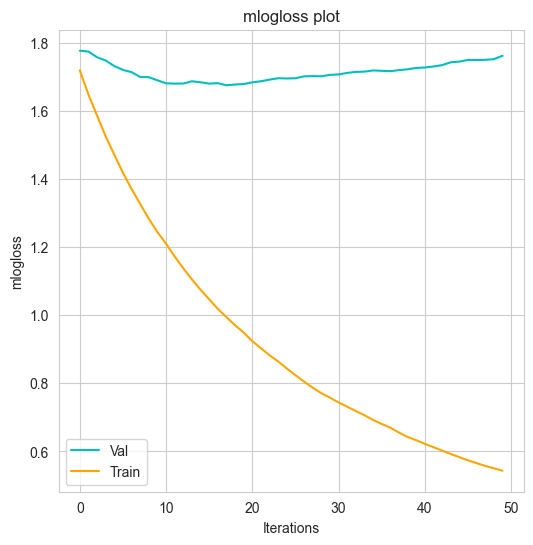

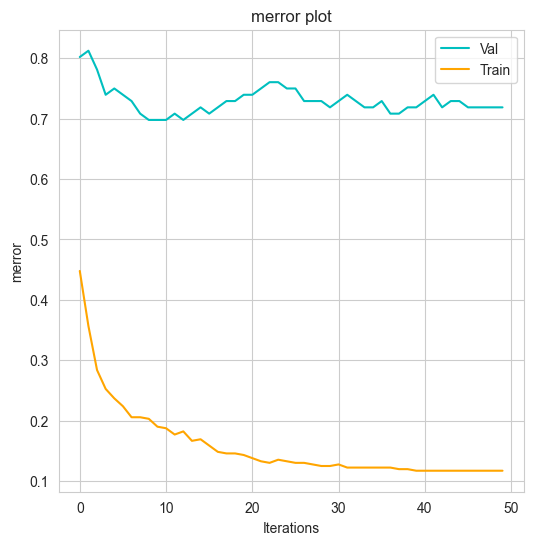

In [276]:
training_data = {'X_train':X_train,'Y_train':y_train,
                'X_val': X_val,'Y_val':y_val,
                'X_test': X_test,'Y_test':list(y_test)} # for some reason I need a list here
fitXgb(xgb1, training_data, 50)

In [277]:
preds = xgb1.predict(X_test)
labels = list(y_test)
#print(confusion_matrix(labels, preds))
print(accuracy_score(labels, preds))
print(recall_score(labels, preds, average='macro'))
print(precision_score(labels, preds, average='macro'))
print(f1_score(labels, preds, average = 'macro'))

0.2916666666666667
0.28549922299922303
0.2528464590964591
0.2613516166147745


## Tuning XGBoost Parameters

In [278]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

In [226]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'n_estimators': range(5000,10000,2000)
}

gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch1.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=10000,
                                     n_jobs=None, nthread=4, num_class=6, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2),
                         'n_estimators': range(6000, 10000, 2000)},
             scoring='f1_micro', verbose=10)

In [227]:
getTrainScores(gsearch1)

({0: "mean:nanparams{'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 6000}",
  1: "mean:nanparams{'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 8000}",
  2: "mean:nanparams{'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 6000}",
  3: "mean:nanparams{'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 8000}",
  4: "mean:nanparams{'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 6000}",
  5: "mean:nanparams{'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 8000}",
  6: "mean:nanparams{'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 6000}",
  7: "mean:nanparams{'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 8000}",
  8: "mean:nanparams{'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 6000}",
  9: "mean:nanparams{'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 8000}",
  10: "mean:nanparams{'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 6000}",
  11: "mean:nanparams{'max_depth': 5, 'min_child_weight': 5, 'n_estimators'

In [279]:
xgb2 = XGBClassifier(learning_rate=0.1,
                    n_estimators=6000,
                    max_depth=3,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softprob',
                    nthread=4,
                    num_class = 6,
                    seed=2789)

Fitting model...
Fitting done!
[0]	val-mlogloss:1.77438	val-merror:0.78125	train-mlogloss:1.74276	train-merror:0.53646
[5]	val-mlogloss:1.72798	val-merror:0.73958	train-mlogloss:1.54099	train-merror:0.38281
[10]	val-mlogloss:1.68348	val-merror:0.76042	train-mlogloss:1.40104	train-merror:0.33073
[15]	val-mlogloss:1.66520	val-merror:0.70833	train-mlogloss:1.28244	train-merror:0.30729
[20]	val-mlogloss:1.66698	val-merror:0.71875	train-mlogloss:1.18752	train-merror:0.27604
[25]	val-mlogloss:1.66785	val-merror:0.72917	train-mlogloss:1.10752	train-merror:0.25781
[30]	val-mlogloss:1.67540	val-merror:0.73958	train-mlogloss:1.04165	train-merror:0.24219
[35]	val-mlogloss:1.67989	val-merror:0.72917	train-mlogloss:0.98279	train-merror:0.22135
[40]	val-mlogloss:1.69078	val-merror:0.69792	train-mlogloss:0.92902	train-merror:0.20573
[45]	val-mlogloss:1.69774	val-merror:0.72917	train-mlogloss:0.88002	train-merror:0.18490
[49]	val-mlogloss:1.70525	val-merror:0.75000	train-mlogloss:0.84566	train-merror:

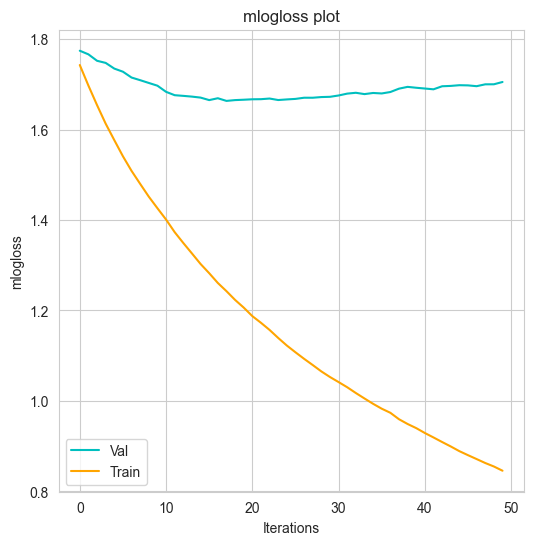

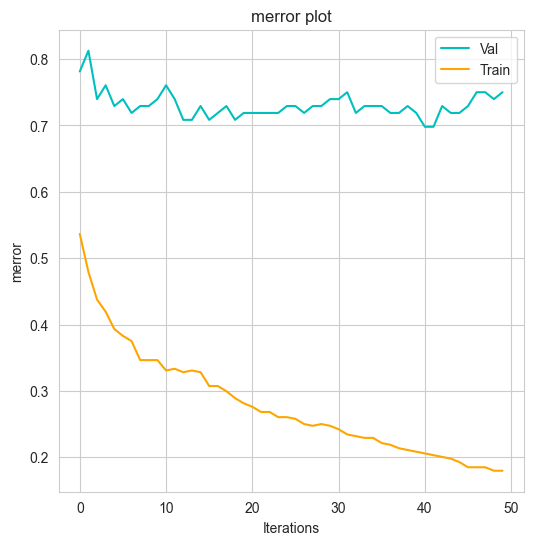

In [280]:
fitXgb(xgb2, training_data, 50)

In [281]:
preds = xgb2.predict(X_test)
labels = list(y_test)
#print(confusion_matrix(labels, preds))
print(accuracy_score(labels, preds))
print(recall_score(labels, preds, average='macro'))
print(precision_score(labels, preds, average='macro'))
print(f1_score(labels, preds, average = 'macro'))

0.2833333333333333
0.2896756021756022
0.2531030272409583
0.257981960228235


## LSTM

In [82]:
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 110)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state= 8) # 0.25 x 0.8 = 0.2

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(y_train.shape))
print("y val shape: {}".format(y_test.shape))

X_train shape: (384, 34)
X_test shape: (120, 34)
y_train shape: (384,)
y_test shape: (120,)
X_val shape: (384,)
y val shape: (120,)


In [88]:

# The input text, example could be list of sentences
texts = cleaned_corpus

# The labels corresponding to the input text
labels = list(song_lyric_df['genre_label'])

# Hyperparameters 
max_words = 100000 # max number of words to use in the vocabulary
max_len = 500 # max length of each text (in terms of number of words)
embedding_dim = 100 # dimension of word embeddings
lstm_units = 64 # number of units in the LSTM layer
num_classes = len(set(labels)) # number of classes

# Tokenize the texts and create a vocabulary
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad the sequences so they all have the same length
x = pad_sequences(sequences, maxlen=max_len)

# Create one-hot encoded labels
y = keras.utils.to_categorical(labels, num_classes)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# Build the model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(lstm_units))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'recall', 'precision', 'f1_score'])


# Train the model
model.fit(x_train, y_train, batch_size=128, epochs=25, validation_data=(x_test, y_test))

#model.fit(x, y, batch_size=32, epochs=10)


Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 630ms/step - accuracy: 0.1909 - f1_score: 0.1809 - loss: 1.7908 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1917 - val_f1_score: 0.1718 - val_loss: 1.7898 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - accuracy: 0.3997 - f1_score: 0.3864 - loss: 1.7745 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2083 - val_f1_score: 0.1916 - val_loss: 1.7879 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 406ms/step - accuracy: 0.5877 - f1_score: 0.5921 - loss: 1.7553 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2000 - val_f1_score: 0.1909 - val_loss: 1.7853 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - accuracy: 0.7306 - f1_score: 0.7360 - loss: 1.7236 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2250 - val_f1_score: 0.2130 - val_lo

In [89]:
results = model.evaluate(x_train, y_train, verbose=0)

accuracy = results[1] * 100
recall = results[2] * 100
precision = results[3] * 100
f1_score = results[4] * 100
print('Accuracy: %f' % accuracy)
print('Recall: %f' % recall)
print('Precision: %f' % precision)
print('F1 Score: %f' % np.mean(f1_score))


Accuracy: 90.416664
Recall: 87.916666
Precision: 93.986636
F1 Score: 90.344627


In [309]:
f1_score

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([29.41176 ,  7.407402, 21.621616,  0.      , 27.02702 , 26.923073],
      dtype=float32)>

In [90]:
results = model.evaluate(x_test, y_test, verbose=0)

accuracy = results[1] * 100
recall = results[2] * 100
precision = results[3] * 100
f1_score = results[4] * 100
print('Accuracy: %f' % accuracy)
print('Recall: %f' % recall)
print('Precision: %f' % precision)
print('F1 Score: %f' % np.mean(f1_score))

Accuracy: 31.666666
Recall: 28.333333
Precision: 32.692307
F1 Score: 29.743940


In [ ]:
param_test1 = {
 #'max_words':range(1,100000,25000),
 'max_len':range(1,1000,250),
 'embedding_dim':range(1,500,100),
 'lstmn_units':range(1,256,32)
}

gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch1.fit(x_train, y_train)

In [77]:
def make_lstm_prediction(url):
    new_lyric = get_lyrics(url)
    new_text = text_preprocessing(new_lyric)  # You need to define preprocess_text function
    # Tokenize the new text
    new_sequence = tokenizer.texts_to_sequences([new_text])
    
    # Pad the sequence
    new_padded_sequence = pad_sequences(new_sequence, maxlen=max_len)
    
    # Make predictions
    predictions = model.predict(new_padded_sequence)
    
    predicted_genre_index = np.argmax(predictions)
    #print(predicted_genre_index)
    genre_labels = ['Hip-hop', 'Rock', 'Country', 'Pop', 'RnB', 'Singer/Songwriter']
    predicted_genre = genre_labels[predicted_genre_index]
    return predicted_genre


In [84]:
make_lstm_prediction('https://www.azlyrics.com/lyrics/kanyewest/offthegrid.html')


NameError: name 'get_lyrics' is not defined

In [345]:
make_lstm_prediction('https://www.azlyrics.com/lyrics/acdc/thunderstruck.html')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


'Rock'

In [350]:
make_lstm_prediction('https://www.azlyrics.com/lyrics/taylorswift/willow.html')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


'Hip-hop'

## Random Forest

In [312]:
def stratified_split(df, target, val_percent=0.2):
    '''
    Function to split a dataframe into train and validation sets, while preserving the ratio of the labels in the target variable
    Inputs:
    - df, the dataframe
    - target, the target variable
    - val_percent, the percentage of validation samples, default 0.2
    Outputs:
    - train_idxs, the indices of the training dataset
    - val_idxs, the indices of the validation dataset
    '''
    classes=list(df[target].unique())
    train_idxs, val_idxs = [], []
    for c in classes:
        idx=list(df[df[target]==c].index)
        np.random.shuffle(idx)
        val_size=int(len(idx)*val_percent)
        val_idxs+=idx[:val_size]
        train_idxs+=idx[val_size:]
    return train_idxs, val_idxs


train_idxs, val_idxs = stratified_split(song_lyric_df, 'genre', val_percent=0.25)
val_idxs, test_idxs = stratified_split(song_lyric_df[song_lyric_df.index.isin(val_idxs)], 'genre', val_percent=0.5)

In [86]:
def test_stratified(df, col):
    '''
    Analyzes the ratio of different classes in a categorical variable within a dataframe
    Inputs:
    - dataframe
    - categorical column to be analyzed
    Returns: None
    '''
    classes=list(df[col].unique())
    
    for c in classes:
        print(f'Proportion of records with {c}: {len(df[df[col]==c])*1./len(df):0.2} ({len(df[df[col]==c])} / {len(df)})')

In [87]:
print('---------- STRATIFIED SAMPLING REPORT ----------')
print('-------- Label proportions in FULL data --------')
test_stratified(song_lyric_df, 'genre')
print('-------- Label proportions in TRAIN data --------')
test_stratified(song_lyric_df[song_lyric_df.index.isin(train_idxs)], 'genre')
print('------ Label proportions in VALIDATION data -----')
test_stratified(song_lyric_df[song_lyric_df.index.isin(val_idxs)], 'genre')
print('-------- Label proportions in TEST data ---------')
test_stratified(song_lyric_df[song_lyric_df.index.isin(test_idxs)], 'genre')

---------- STRATIFIED SAMPLING REPORT ----------
-------- Label proportions in FULL data --------
Proportion of records with Hiphop: 0.17 (100 / 600)
Proportion of records with Rock: 0.17 (100 / 600)
Proportion of records with Country: 0.17 (100 / 600)
Proportion of records with Pop: 0.17 (100 / 600)
Proportion of records with RnB: 0.17 (100 / 600)
Proportion of records with Singer/Songwriter: 0.17 (100 / 600)
-------- Label proportions in TRAIN data --------
Proportion of records with Hiphop: 0.17 (75 / 450)
Proportion of records with Rock: 0.17 (75 / 450)
Proportion of records with Country: 0.17 (75 / 450)
Proportion of records with Pop: 0.17 (75 / 450)
Proportion of records with RnB: 0.17 (75 / 450)
Proportion of records with Singer/Songwriter: 0.17 (75 / 450)
------ Label proportions in VALIDATION data -----
Proportion of records with Hiphop: 0.17 (13 / 78)
Proportion of records with Rock: 0.17 (13 / 78)
Proportion of records with Country: 0.17 (13 / 78)
Proportion of records with 

In [313]:
train_df = song_lyric_df[song_lyric_df.index.isin(train_idxs)]
X_train = train_df['CleanedLyrics']
Y_train = train_df[['genre']].values
print('Retrieved Training Data')
val_df = song_lyric_df[song_lyric_df.index.isin(val_idxs)]
X_val = val_df['CleanedLyrics']
Y_val = val_df[['genre']].values
print('Retrieved Validation Data')
test_df = song_lyric_df[song_lyric_df.index.isin(test_idxs)]
X_test = test_df['CleanedLyrics']
Y_test = test_df[['genre']].values
print('Retrieved Test Data')

Retrieved Training Data
Retrieved Validation Data
Retrieved Test Data


In [314]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df = 0.2, max_features=10000)
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(X_train)
xtest_tfidf  = tfidf_vectorizer.transform(X_test)
xval_tfidf = tfidf_vectorizer.transform(X_val)

In [315]:
#store data, all in numpy arrays
training_data = {'X_train': xtrain_tfidf, 'Y_train': Y_train,
                 'X_val': xval_tfidf, 'Y_val': Y_val,
                 'X_test': xtest_tfidf, 'Y_test': Y_test}

In [316]:
clf = RandomForestClassifier(n_jobs=None,random_state=27, verbose=1)
clf.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


RandomForestClassifier(random_state=27, verbose=1)

In [321]:
preds = clf.predict(training_data['X_test'])
labels = training_data['Y_test']
#print(confusion_matrix(list(labels), preds))

f1_value = f1_score(list(labels), preds, average='macro', zero_division=True) * 100

print(accuracy_score(list(labels), preds)*100,'%')
print(recall_score(list(labels), preds, average='macro', zero_division=True)*100,'%')
print(precision_score(list(labels), preds, average='macro', zero_division=True)*100,'%')
print(f'F1 Score (Macro): {f1_value}%')


34.72222222222222 %
34.722222222222214 %
31.671759612936086 %
F1 Score (Macro): 32.76630915311575%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [322]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

In [333]:
params = {
    'n_estimators'      : range(100,10000,1000),
    'max_depth'         : [8, 9, 10, 11, 12],
}

gsearch1 = GridSearchCV(estimator = clf, param_grid = params, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch1.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    4.6s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=27, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [8, 9, 10, 11, 12],
                         'n_estimators': range(100, 10000, 1000)},
             scoring='f1_micro', verbose=10)

In [334]:
getTrainScores(gsearch1)

({0: "mean:0.35777777777777775params{'max_depth': 8, 'n_estimators': 100}",
  1: "mean:0.3866666666666666params{'max_depth': 8, 'n_estimators': 1100}",
  2: "mean:0.3888888888888889params{'max_depth': 8, 'n_estimators': 2100}",
  3: "mean:0.38params{'max_depth': 8, 'n_estimators': 3100}",
  4: "mean:0.38params{'max_depth': 8, 'n_estimators': 4100}",
  5: "mean:0.38params{'max_depth': 8, 'n_estimators': 5100}",
  6: "mean:0.37777777777777777params{'max_depth': 8, 'n_estimators': 6100}",
  7: "mean:0.37555555555555553params{'max_depth': 8, 'n_estimators': 7100}",
  8: "mean:0.38params{'max_depth': 8, 'n_estimators': 8100}",
  9: "mean:0.37555555555555553params{'max_depth': 8, 'n_estimators': 9100}",
  10: "mean:0.3355555555555555params{'max_depth': 9, 'n_estimators': 100}",
  11: "mean:0.3688888888888888params{'max_depth': 9, 'n_estimators': 1100}",
  12: "mean:0.36888888888888893params{'max_depth': 9, 'n_estimators': 2100}",
  13: "mean:0.3644444444444444params{'max_depth': 9, 'n_estima

In [335]:
clf2 = gsearch1.best_estimator_

params1 = {
    'max_depth'         : range(7, 10, 1),
    'n_estimators' : range(2000, 2200, 50)
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch2 = GridSearchCV(estimator = clf2, param_grid = params1, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch2.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    4.5s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=8, n_estimators=2100,
                                              random_state=27, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': range(7, 10),
                         'n_estimators': range(2000, 2200, 50)},
             scoring='f1_micro', verbose=10)

In [336]:
getTrainScores(gsearch2)

({0: "mean:0.3688888888888889params{'max_depth': 7, 'n_estimators': 2000}",
  1: "mean:0.37333333333333335params{'max_depth': 7, 'n_estimators': 2050}",
  2: "mean:0.3711111111111111params{'max_depth': 7, 'n_estimators': 2100}",
  3: "mean:0.37333333333333335params{'max_depth': 7, 'n_estimators': 2150}",
  4: "mean:0.38666666666666666params{'max_depth': 8, 'n_estimators': 2000}",
  5: "mean:0.3888888888888889params{'max_depth': 8, 'n_estimators': 2050}",
  6: "mean:0.3888888888888889params{'max_depth': 8, 'n_estimators': 2100}",
  7: "mean:0.3866666666666666params{'max_depth': 8, 'n_estimators': 2150}",
  8: "mean:0.36888888888888893params{'max_depth': 9, 'n_estimators': 2000}",
  9: "mean:0.3711111111111111params{'max_depth': 9, 'n_estimators': 2050}",
  10: "mean:0.36888888888888893params{'max_depth': 9, 'n_estimators': 2100}",
  11: "mean:0.3666666666666667params{'max_depth': 9, 'n_estimators': 2150}"},
 {'best_mean': 0.3888888888888889,
  'best_param': {'max_depth': 8, 'n_estimator

In [179]:
predicted_labels = clf2.predict(training_data['X_test'])
accuracy_score(training_data['Y_test'], predicted_labels)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.2s


0.3472222222222222

In [337]:
preds = clf2.predict(training_data['X_test'])


labels = training_data['Y_test']
#print(confusion_matrix(list(labels), preds))

f1_value = f1_score(list(labels), preds, average='macro', zero_division=True) * 100

print(accuracy_score(list(labels), preds)*100,'%')
print(recall_score(list(labels), preds, average='macro', zero_division=True)*100,'%')
print(precision_score(list(labels), preds, average='macro', zero_division=True)*100,'%')
print(f'F1 Score (Macro): {f1_value}%')

38.88888888888889 %
38.88888888888889 %
35.64102564102564 %
F1 Score (Macro): 36.94276094276094%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.0s


In [338]:
clf3 = gsearch2.best_estimator_
params3 = {
    'max_depth'         : range(7,9,1),
    'n_estimators'      : range(2025, 2075, 5)
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch3 = GridSearchCV(estimator = clf3, param_grid = params3, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch3.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    6.4s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=8, n_estimators=2050,
                                              random_state=27, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': range(7, 9),
                         'n_estimators': range(2025, 2075, 5)},
             scoring='f1_micro', verbose=10)

In [339]:
getTrainScores(gsearch3)

({0: "mean:0.3688888888888889params{'max_depth': 7, 'n_estimators': 2025}",
  1: "mean:0.3688888888888889params{'max_depth': 7, 'n_estimators': 2030}",
  2: "mean:0.3688888888888889params{'max_depth': 7, 'n_estimators': 2035}",
  3: "mean:0.3688888888888889params{'max_depth': 7, 'n_estimators': 2040}",
  4: "mean:0.3688888888888889params{'max_depth': 7, 'n_estimators': 2045}",
  5: "mean:0.37333333333333335params{'max_depth': 7, 'n_estimators': 2050}",
  6: "mean:0.3688888888888889params{'max_depth': 7, 'n_estimators': 2055}",
  7: "mean:0.3711111111111111params{'max_depth': 7, 'n_estimators': 2060}",
  8: "mean:0.3711111111111111params{'max_depth': 7, 'n_estimators': 2065}",
  9: "mean:0.3711111111111111params{'max_depth': 7, 'n_estimators': 2070}",
  10: "mean:0.38666666666666666params{'max_depth': 8, 'n_estimators': 2025}",
  11: "mean:0.38666666666666666params{'max_depth': 8, 'n_estimators': 2030}",
  12: "mean:0.3888888888888889params{'max_depth': 8, 'n_estimators': 2035}",
  13: 

In [340]:
final_clf = gsearch3.best_estimator_
final_clf.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))
predicted_labels = final_clf.predict(training_data['X_test'])
train_pred = final_clf.predict(training_data['X_train'])
print('Train Accuracy:'+str(accuracy_score(training_data['Y_train'], train_pred)))
print('Train F1-Score(Micro):'+str(f1_score(training_data['Y_train'], train_pred,average='micro')))
print('------')
#print('Test Accuracy:'+str(accuracy_score(training_data['Y_test'], predicted_labels)))
#print('Test F1-Score(Micro):'+str(f1_score(training_data['Y_test'], predicted_labels,average='micro')))



preds = final_clf.predict(training_data['X_test'])
labels = training_data['Y_test']
#print(confusion_matrix(list(labels), preds))

f1_value = f1_score(list(labels), preds, average='macro', zero_division=True) * 100

print(accuracy_score(list(labels), preds)*100,'%')
print(recall_score(list(labels), preds, average='macro', zero_division=True)*100,'%')
print(precision_score(list(labels), preds, average='macro', zero_division=True)*100,'%')
print(f'F1 Score (Macro): {f1_value}%')

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]

Train Accuracy:0.9088888888888889
Train F1-Score(Micro):0.9088888888888889
------
38.88888888888889 %
38.88888888888889 %
35.64102564102564 %
F1 Score (Macro): 36.94276094276094%


[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.0s


In [111]:
y_train

array([[0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [455]:
y_test

array([5, 1, 0, 1, 3, 2, 1, 4, 5, 3, 0, 2, 0, 0, 2, 1, 0, 1, 0, 1, 1, 2,
       2, 4, 1, 3, 0, 2, 5, 0, 1, 4, 1, 4, 5, 2, 5, 2, 5, 3, 3, 1, 2, 1,
       4, 1, 3, 0, 3, 0, 5, 5, 0, 1, 5, 1, 3, 3, 0, 3, 2, 3, 0, 0, 1, 4,
       1, 1, 5, 3, 3, 4, 5, 3, 4, 0, 5, 5, 5, 4, 1, 1, 2, 2, 0, 5, 5, 4,
       3, 0, 4, 3, 5, 2, 4, 2, 1, 2, 5, 3, 1, 5, 3, 0, 0, 4, 5, 3, 2, 0,
       0, 0, 5, 3, 5, 3, 0, 2, 0, 2], dtype=object)

**Creating barplots for evaluation metrics**

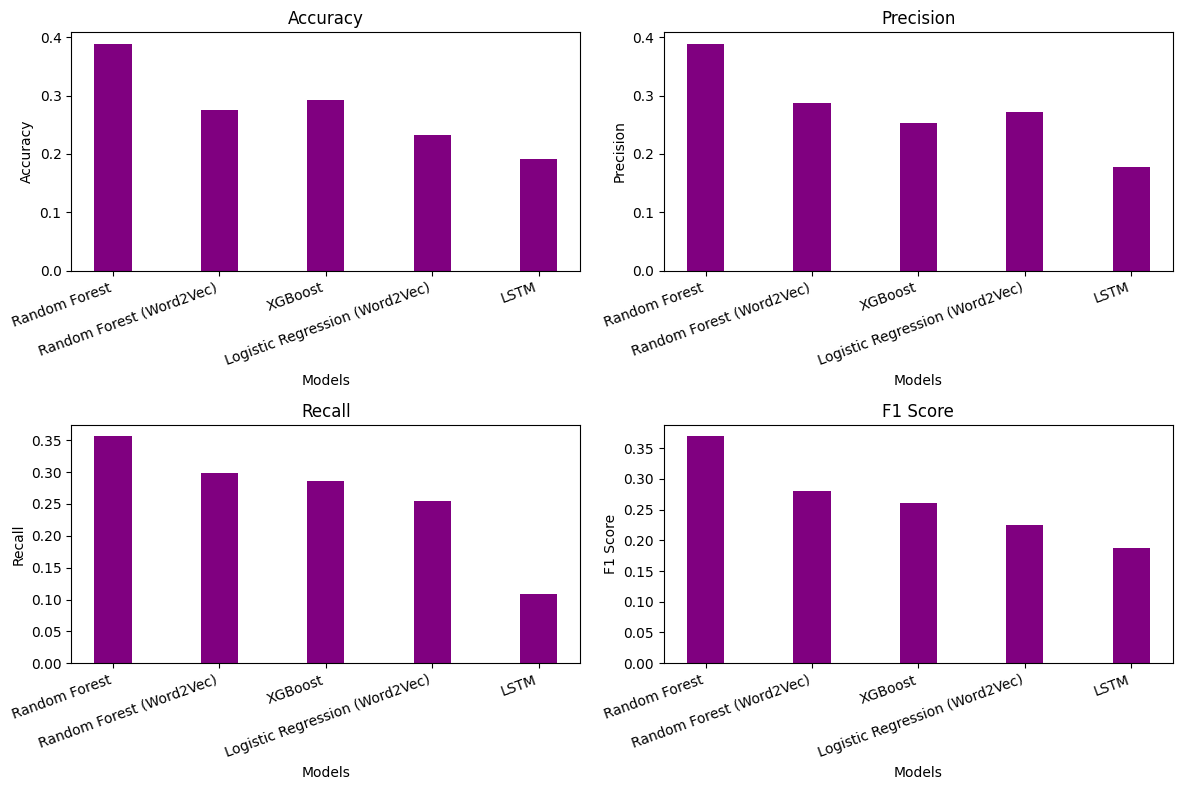

In [29]:
# Define model names and evaluation metrics
models = ["Random Forest", "Random Forest (Word2Vec)", "XGBoost", "Logistic Regression (Word2Vec)", "LSTM"]
metrics = ["Accuracy", "Precision", "Recall",  "F1 Score"]

# Create random data for evaluation metrics (assuming you have your own data)
data = {
    "Accuracy": [0.3889, 0.275, 0.2917, 0.2333, 0.1917],
    "Precision": [0.3889, 0.288, 0.2528, 0.2725, 0.1781],
    "Recall": [0.3564, 0.298, 0.2855, 0.2544, 0.1083],
    "F1 Score": [0.3694, 0.2803, 0.2614, 0.2249, 0.1872]
}

# Define width of bars and space between groups
width = 0.35
index = range(len(models))

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Loop through each metric and create bar plots
for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    ax.bar(index, data[metric], width, label=metric, color = 'purple')
    ax.set_xlabel("Models")
    ax.set_ylabel(metric)
    ax.set_title(metric)
    ax.set_xticks(index)
    ax.set_xticklabels(models, rotation=20, ha="right")
#    ax.legend()

# Tight layout to avoid overlapping elements
plt.tight_layout()

# Show the bar plots
plt.show()


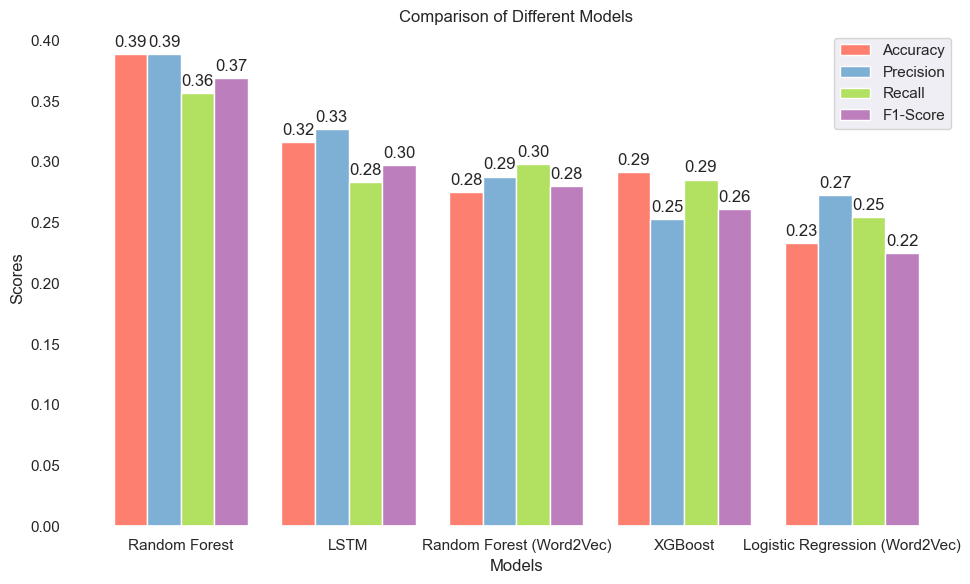

In [91]:
models = ["Random Forest", "LSTM", "Random Forest (Word2Vec)", "XGBoost", "Logistic Regression (Word2Vec)"]
metrics = ["Accuracy", "Precision", "Recall",  "F1 Score"]

# Create random data for evaluation metrics (assuming you have your own data
accuracy = [0.3889, 0.3167, 0.275, 0.2917, 0.233]
precision = [0.3889, 0.3269, 0.288, 0.2528, 0.2725]
recall = [0.3564, 0.2833, 0.298, 0.2855, 0.2544]
f1_score = [0.3694, 0.2974, 0.2803, 0.2614, 0.2249]

# Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1_score]

# X-axis positions
x = np.arange(len(models))

# Width of the bars
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

# Define custom colors for each metric

# Plotting each metric
rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy', color = "#fd7f6f")
rects2 = ax.bar(x - 0.5*width, precision, width, label='Precision', color = "#7eb0d5")
rects3 = ax.bar(x + 0.5*width, recall, width, label='Recall', color = "#b2e061")
rects4 = ax.bar(x + 1.5*width, f1_score, width, label='F1-Score', color = "#bd7ebe")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_facecolor('white')
ax.legend()

# Attach a text label above each bar, displaying its height
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()
